In [1]:
import cv2
import parsers
import pipeline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Parse DICOM and Contours

In [2]:
link = 'link.csv'
batch_size = 8
pipe = pipeline.TrainingPipeline(link, batch_size)

Preparing training data...


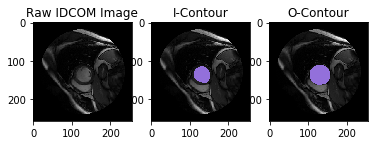

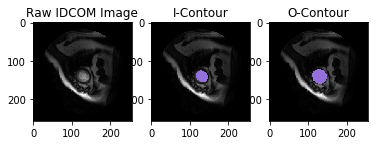

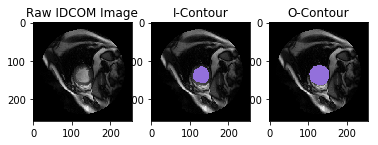

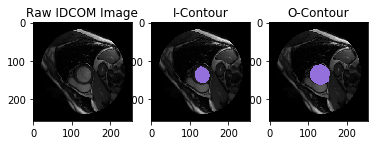

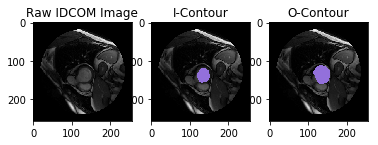

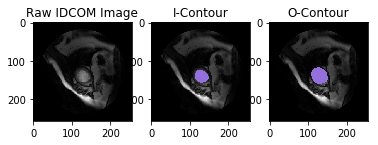

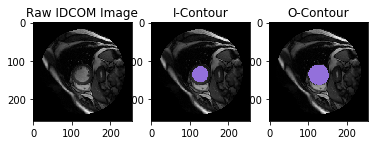

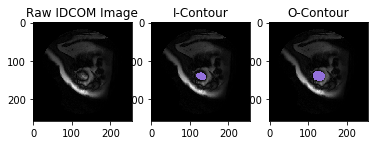

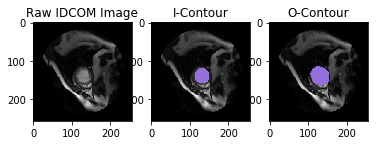

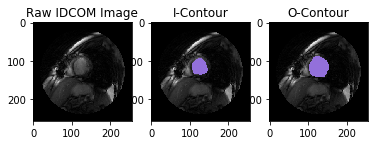

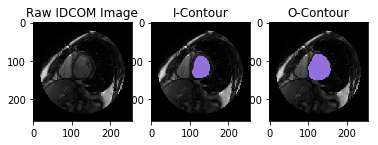

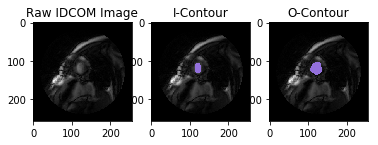

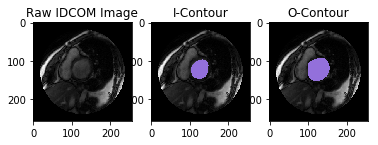

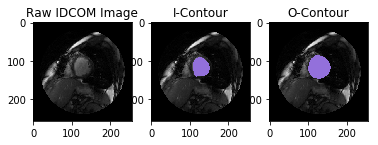

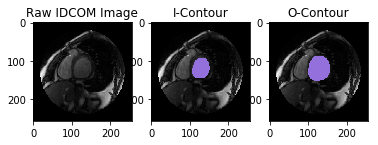

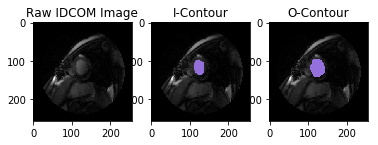

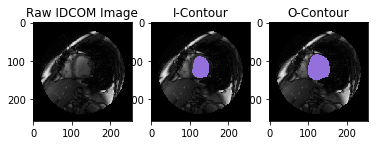

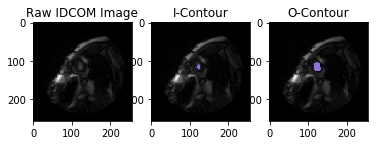

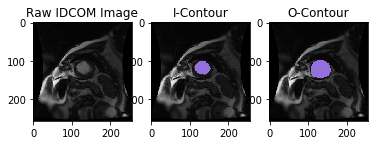

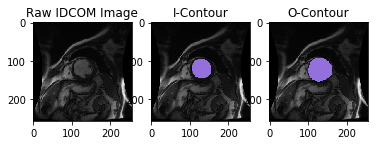

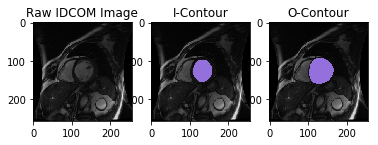

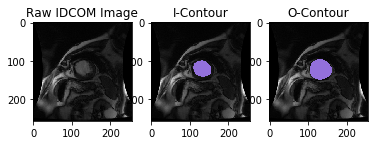

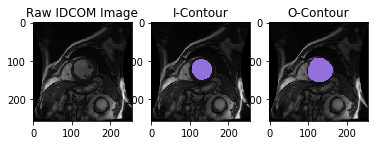

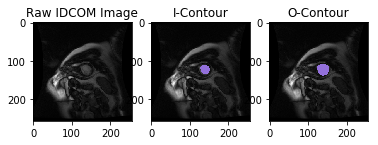

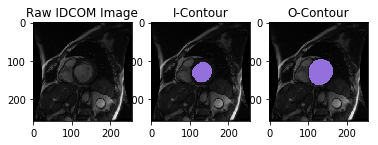

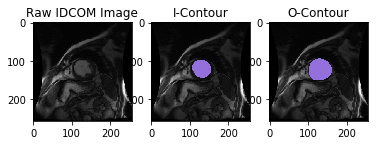

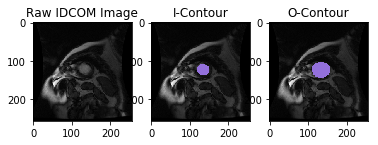

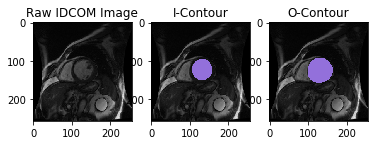

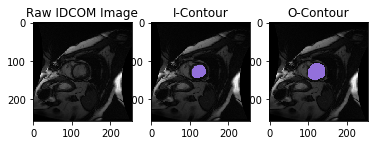

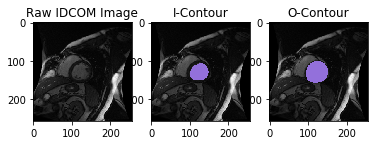

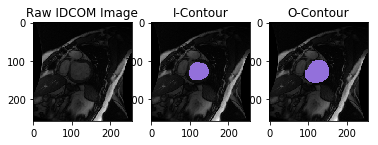

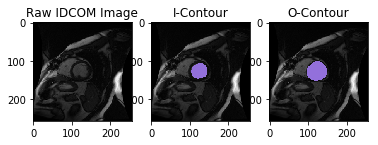

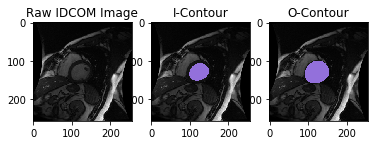

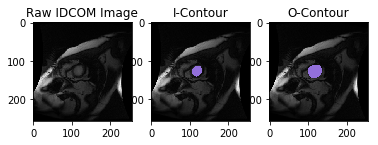

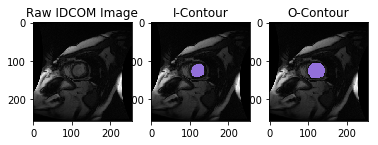

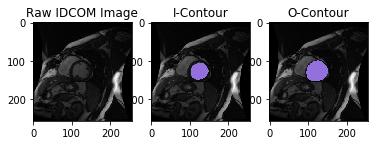

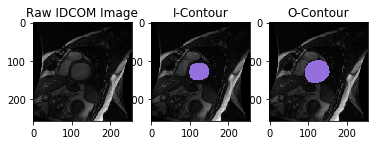

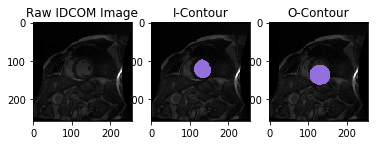

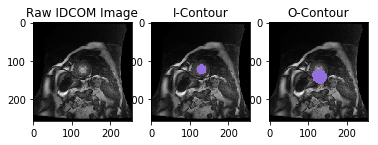

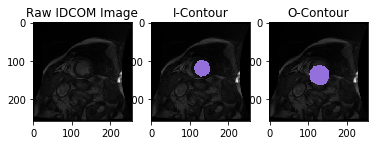

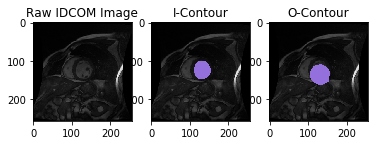

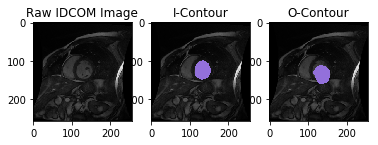

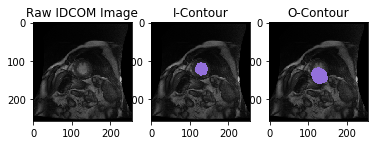

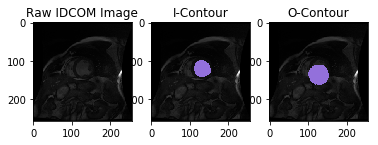

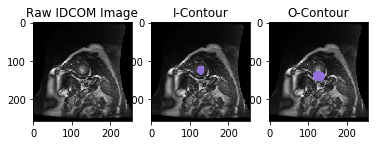

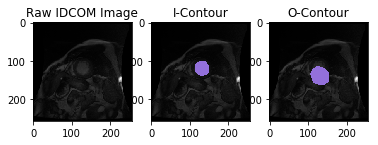

In [3]:
pipe.prepare_training_data(visualize=True)
dicom_data = pipe._inputs
masks_data = pipe._targets

## Compare pixel intensities of blood pool to heart muscle

In [4]:
dicoms = dicom_data[:, :, :, 0]
icontours = masks_data[:, :, :, 0, 0]
ocontours = masks_data[:, :, :, 0, 1]
print 'dicoms shape: \t\t', dicoms.shape
print 'icontours shape: \t', icontours.shape
print 'ocontours.shape: \t', ocontours.shape

dicoms shape: 		(46, 256, 256)
icontours shape: 	(46, 256, 256)
ocontours.shape: 	(46, 256, 256)


** Extract pixel intensities of blood pools and heart muscles for all available data samples **

In [5]:
def get_blood_pool_pixels(dicom, icontour):
    """Extract pixels inside blood pool (pixels inside i-contour)"""

    return dicom[icontour]

In [6]:
def get_heart_muscle_pixels(dicom, icontour, ocontour):
    """Extrat pixels of heart muscle (pixels between i-contour and inside o-contour)"""
    
    return dicom[np.logical_and(ocontour, ~ icontour)]

In [7]:
blood_pool_pixels = []
heart_muscle_pixels = []

for dicom, icontour, ocontour in zip(dicoms, icontours, ocontours):
    blood_pool = get_blood_pool_pixels(dicom, icontour)
    blood_pool_pixels.append(blood_pool)
    heart_muscle = get_heart_muscle_pixels(dicom, icontour, ocontour)
    heart_muscle_pixels.append(heart_muscle)

**Visualize blood pool and heart muscle pixel intensities**

In [8]:
def compare_pixel_intensity_with_threshold(blood_pool, heart_muscle, threshold=None):
    """Plot pixel intensities in histograms to compare the differences btw blood pool and heart muscle with threshold."""
    
    plt.style.use('ggplot')
    plt.hist(blood_pool, alpha=0.5, label='blood pool')
    plt.grid('on')
    plt.hist(heart_muscle, alpha=0.5, label='heart muscle')
    if threshold is not None:
        plt.axvline(x=threshold, label='threshold')
    plt.legend()
    plt.xlabel('pixel intensity')
    axes = plt.gca()
    axes.set_xlim(0, 1.)
    plt.show()

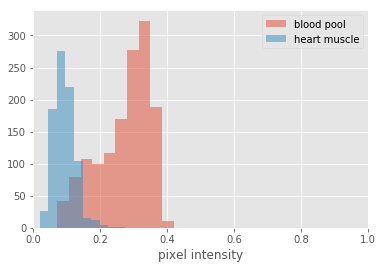

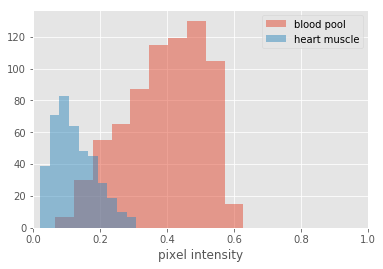

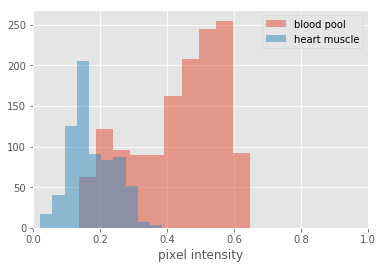

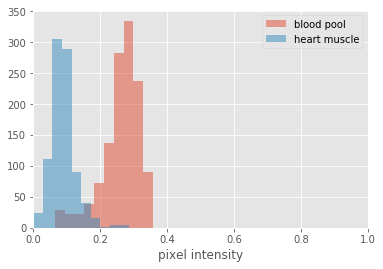

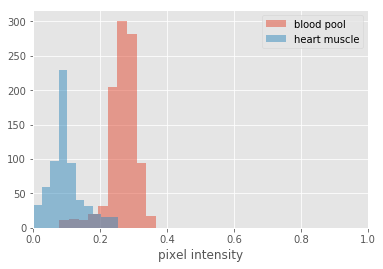

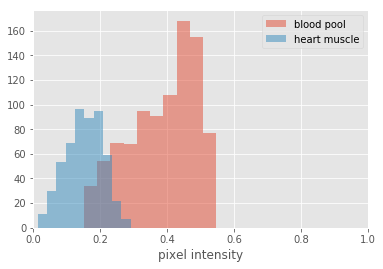

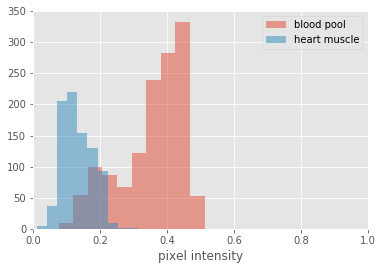

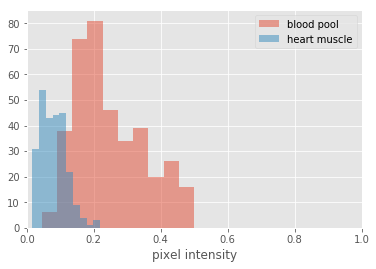

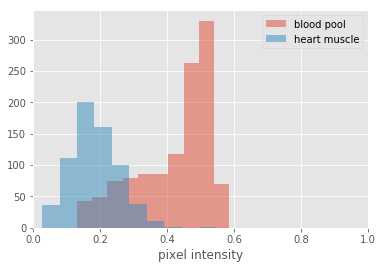

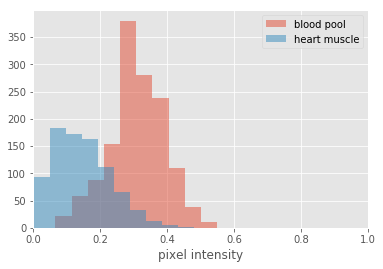

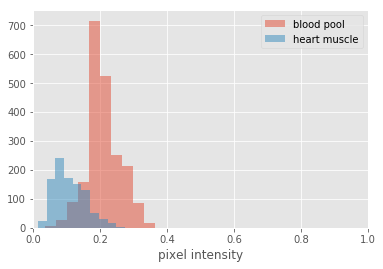

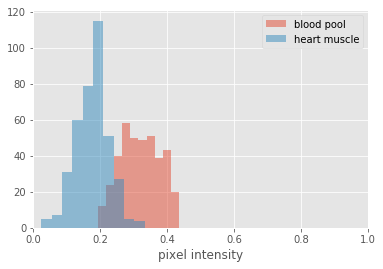

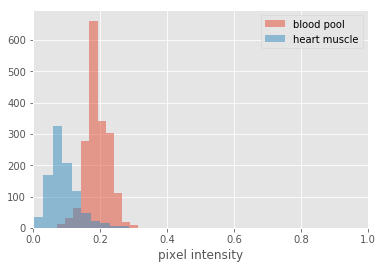

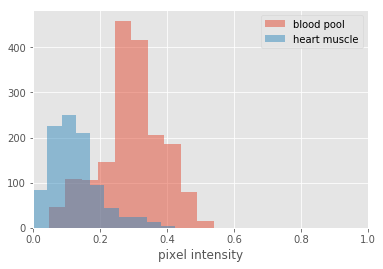

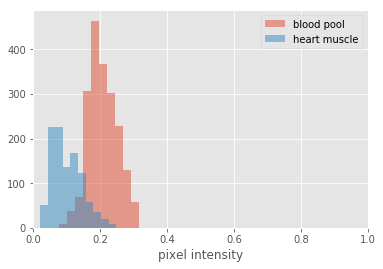

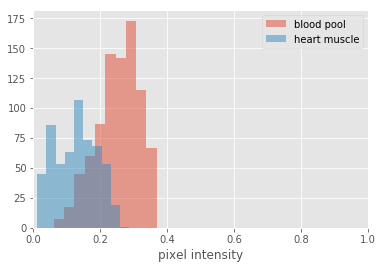

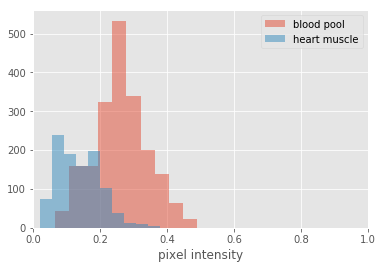

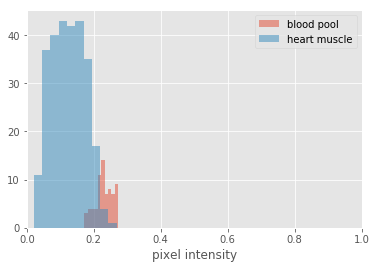

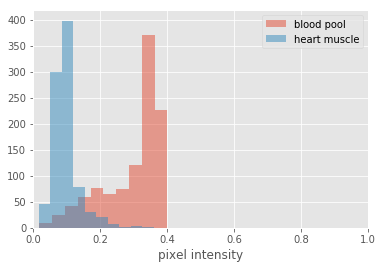

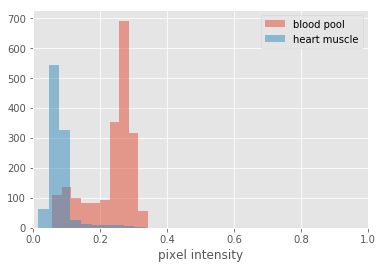

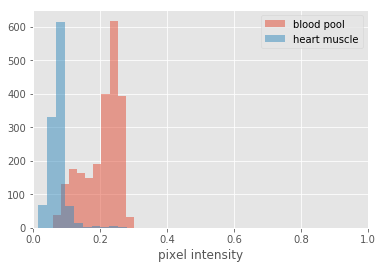

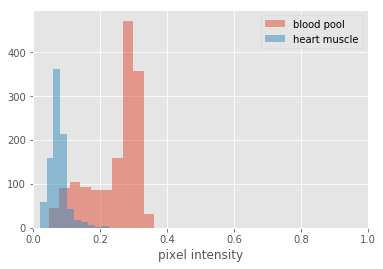

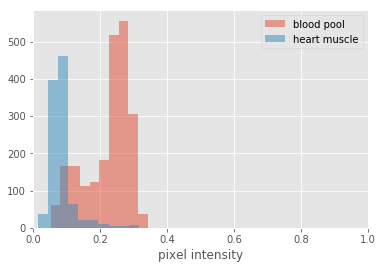

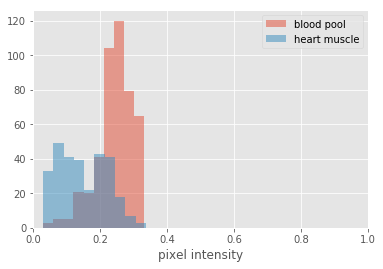

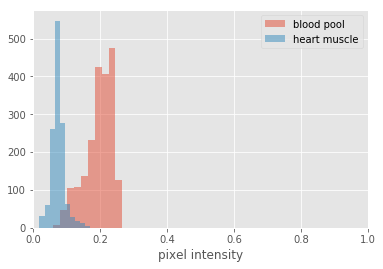

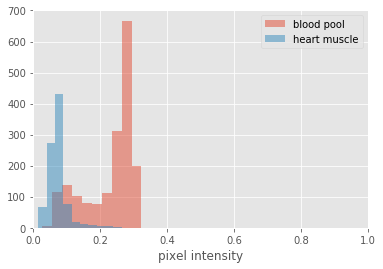

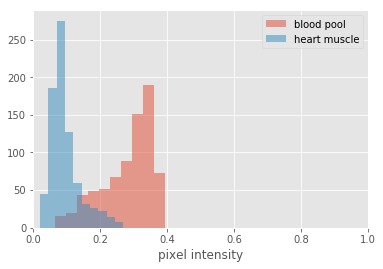

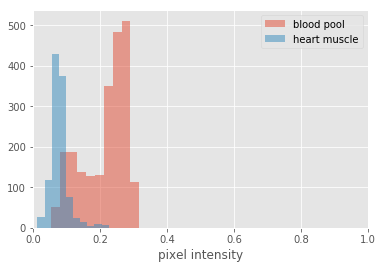

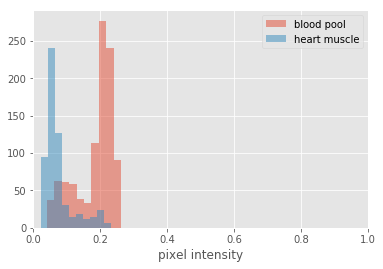

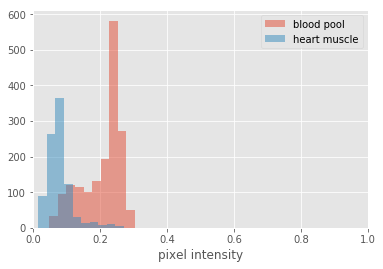

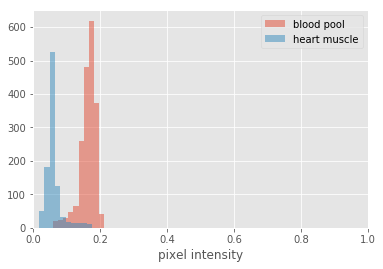

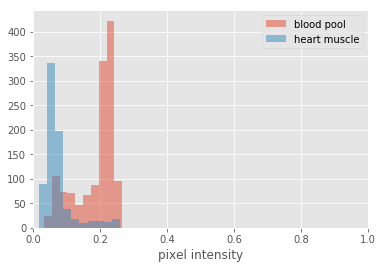

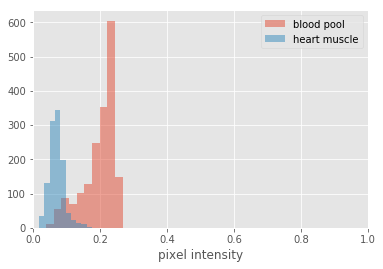

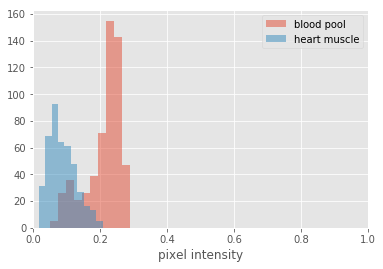

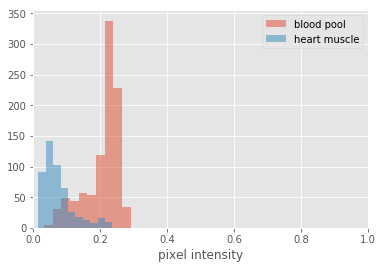

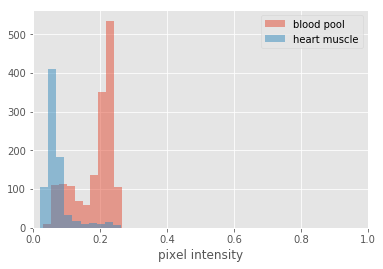

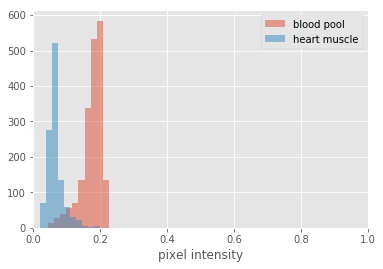

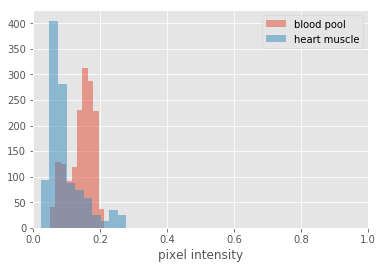

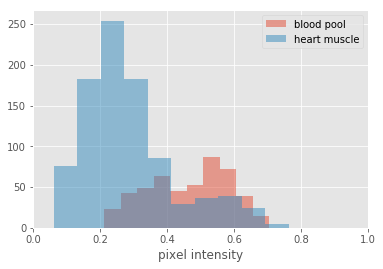

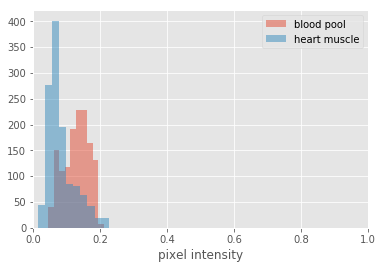

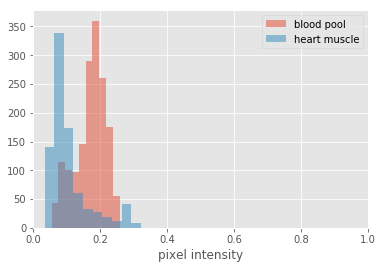

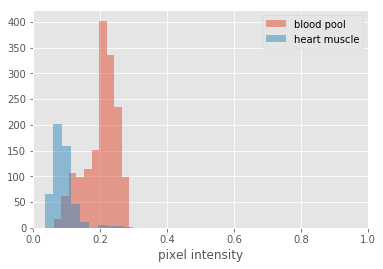

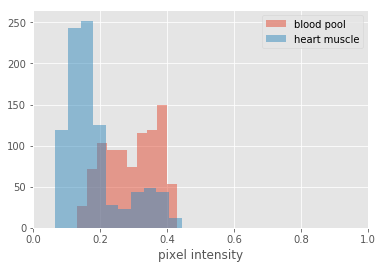

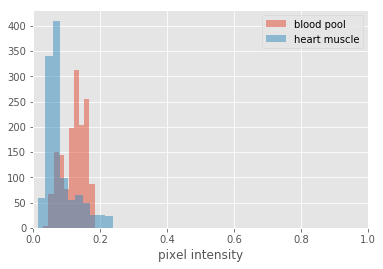

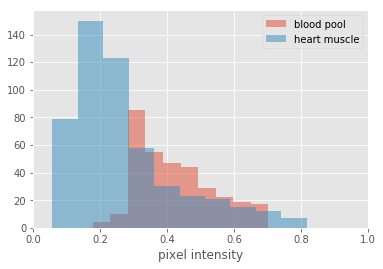

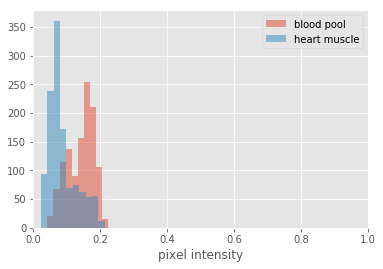

In [9]:
for blood_pool, heart_muscle in zip(blood_pool_pixels, heart_muscle_pixels):
    compare_pixel_intensity_with_threshold(blood_pool, heart_muscle)

### Can a simple thresholding thresholding scheme be used to automatically create the i-contours, given the o-contours?

### Single Fixed-Value Thresholding Scheme

**1. A Qualitative Analysis on single-valued thresholding scheme**

The histograms of the blood pool pixel intensities and the heart muscle intensities above show that despite that the blood pool region tends to have higher pixel intensity value as compared to the heart muscle, however their pixel intensities almost always have an overlapping region (usually in the range of [0.05, 0.25] in terms of normalized pixel intensity value). This overlap makes it **hardly possible** find **a single-valued thresholding scheme** for automatically creating the i-contours given the o-contours.

**2. A Quantitative Analysis on single-valued thresholding scheme - thresholding at 0.2**

Observe the histograms above, it appears that the two types of histograms form a bimodal distribution shape with the local minimum typically range from [0.05, 0.25]. Now, let's examinate the performance of **single-valued thresholding scheme** quantitatvely by thresholding on a fixed value of 0.20. The intersection over union is used as evaluation metric for its wide usage in segmentation evaluation. 

In [10]:
def fixed_value_thresholding(dicom, ocontour, threshold):
    """Apply an universal single fixed value thresholding scheme for predicting i-contour boolean mask."""

    bool_mask = dicom > threshold
    return np.logical_and(bool_mask, ocontour)

In [11]:
def comp_IOU(prediction, ground_truth):
    """Compute Intersection Over Union."""
    
    cnt_intersect = np.logical_and(prediction, ground_truth).sum()
    cnt_union = np.logical_or(prediction, ground_truth).sum()
    return float(cnt_intersect) / cnt_union

In [12]:
def plot_prediction(dicom, omask, imask_gt, imask_pred):
    """Plot DICOM, o-contour mask, ground truth i-contour mask, predicted i-contour mask."""
    
    plt.style.use('classic')
    
    dicom_imsk_gt = parsers.combine_dicom_with_mask(dicom, imask_gt)
    dicom_imsk_pred = parsers.combine_dicom_with_mask(dicom, imask_pred)
    dicom_omsk = parsers.combine_dicom_with_mask(dicom, omask)
    
    f, ax_arr = plt.subplots(1, 4)
    ax_arr[0].imshow(dicom)
    ax_arr[0].set_title('IDCOM Image')
    ax_arr[0].axis('off')
    
    ax_arr[1].imshow(dicom_imsk_gt)
    ax_arr[1].set_title('I-Contour-GT')
    ax_arr[1].axis('off')

    ax_arr[2].imshow(dicom_imsk_pred)
    ax_arr[2].set_title('I-Contour-Pred')
    ax_arr[2].axis('off')
    
    ax_arr[3].imshow(dicom_omsk)
    ax_arr[3].set_title('O-Contour')
    ax_arr[3].axis('off')
    
    plt.show()

In [13]:
def extract_contour_from_boolean_mask(boolean_mask):
    """Extract contour from a 2D boolean mask."""
    
    import cv2
    
    mask = (255 * boolean_mask).astype(np.uint8)
    _, contour, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    return contour

In [14]:
def compare_icontour_masks(dicom, icontour_mask_gt, icontour_mask_pred, ocontour_mask):
    """Plot ground truth and predicted I-Contour Boolean Mask to compare them."""
    
    image = (255 * dicom).astype(np.uint8)
    image = np.repeat(image[:, :, None], 3, 2)
    ocontour = extract_contour_from_boolean_mask(ocontour_mask)

    icontour_gt = extract_contour_from_boolean_mask(icontour_mask_gt)
    icontour_pred = extract_contour_from_boolean_mask(icontour_mask_pred)
    
    img = cv2.drawContours(image.copy(), ocontour, -1, (0, 255, 255), 1)
    
    img_gt = cv2.drawContours(img.copy(), icontour_gt, -1, (255,0,0), 1)
    img_pred = cv2.drawContours(img.copy(), icontour_pred, -1, (255, 0, 0), 1)
    
    plt.style.use('classic')
    plt.subplot(1, 2, 1)
    plt.imshow(img_gt)
    plt.title('Ground Truth')
    
    plt.subplot(1, 2, 2)
    plt.imshow(img_pred)
    plt.title('Prediction')
    plt.show()

**2.1 Apply the single fixed-value thresholding scheme to a single case example**

- ***Case 1 - sample ID: 0***

In [15]:
dicom_example = dicoms[0]
ocontour_example = ocontours[0]
icontour_example = icontours[0]

In [16]:
fixed_threshold = 0.2
icontour_predict = fixed_value_thresholding(dicom_example, ocontour_example, fixed_threshold)

In [17]:
dicom_example3D = np.repeat(dicom_example[:, :, None], 3, 2)
ocontour_example3D = np.repeat(ocontour_example[:, :, None], 3, 2)
icontour_example3D = np.repeat(icontour_example[:, :, None], 3, 2)
icontour_predict3D = np.repeat(icontour_predict[:, :, None], 3, 2)

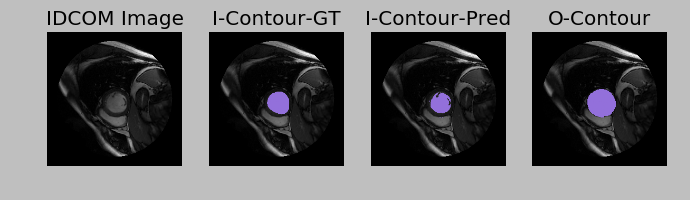

In [18]:
plot_prediction(dicom_example3D, ocontour_example3D, icontour_example3D, icontour_predict3D)

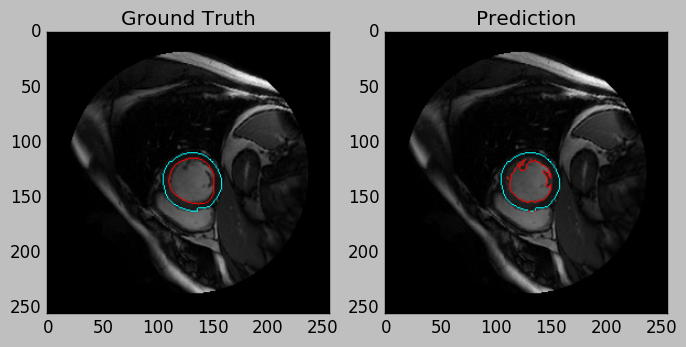

In [19]:
compare_icontour_masks(dicom_example, icontour_example, icontour_predict, ocontour_example)

In [20]:
IOU_score = comp_IOU(icontour_predict, icontour_example)
print('Intersection Over Union Score of fixed value thresholding on one example: %.4f' % (IOU_score))

Intersection Over Union Score of fixed value thresholding on one example: 0.7893


**The single fixed-value thresholding scheme is applied to a single data point and obtain a IOU score of 0.7893. Comparing the predicted i-contour and the ground truth i-contour side by side, there are noticable differences in the plot. The ground truth i-contour is much smoother than the single fixed-value thresholding prediction.**

- ***Case 2 - Sample ID: 2***

In [21]:
dicom_example = dicoms[2]
ocontour_example = ocontours[2]
icontour_example = icontours[2]

In [22]:
fixed_threshold = 0.2
icontour_predict = fixed_value_thresholding(dicom_example, ocontour_example, fixed_threshold)

In [23]:
dicom_example3D = np.repeat(dicom_example[:, :, None], 3, 2)
ocontour_example3D = np.repeat(ocontour_example[:, :, None], 3, 2)
icontour_example3D = np.repeat(icontour_example[:, :, None], 3, 2)
icontour_predict3D = np.repeat(icontour_predict[:, :, None], 3, 2)

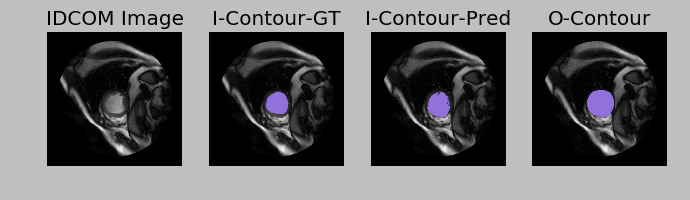

In [24]:
plot_prediction(dicom_example3D, ocontour_example3D, icontour_example3D, icontour_predict3D)

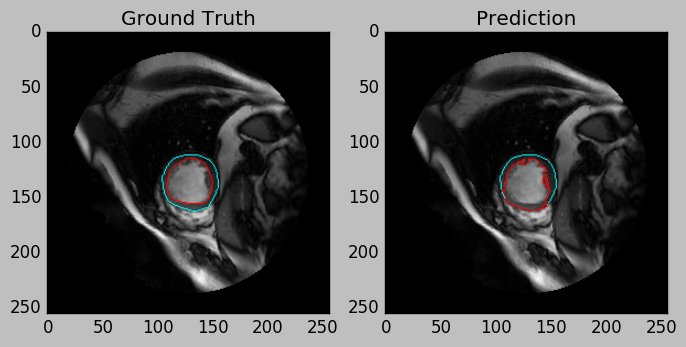

In [25]:
compare_icontour_masks(dicom_example, icontour_example, icontour_predict, ocontour_example)

In [26]:
IOU_score = comp_IOU(icontour_predict, icontour_example)
print('Intersection Over Union Score of fixed value thresholding on one example: %.4f' % (IOU_score))

Intersection Over Union Score of fixed value thresholding on one example: 0.8004


**2.2 Apply the single fixed-value thresholding scheme to all data samples**

In [27]:
IOU_scores = []
fixed_threshold = 0.2
for dicom, icontour, ocontour in zip(dicoms, icontours, ocontours):
    icontour_pred = fixed_value_thresholding(dicom, ocontour, fixed_threshold)
    iou = comp_IOU(icontour_pred, icontour)
    IOU_scores.append(iou)

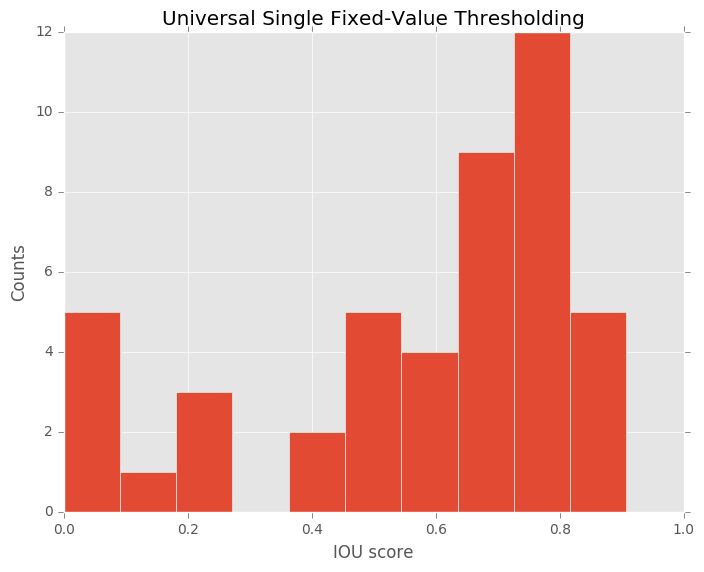

In [28]:
plt.style.use('ggplot')
plt.hist(IOU_scores)
plt.xlabel('IOU score')
plt.ylabel('Counts')
plt.title('Universal Single Fixed-Value Thresholding')
plt.show()

In [29]:
def IOU_stats(iou_scores):
    """An utility function for quickly computing the average and std of an array of IOU scores."""
    
    avg = np.array(iou_scores).mean()
    std = np.array(iou_scores).std()
    print('Mean of IOU scores: %.4f \t Standard Deviation of IOU scores: %.4f' % (avg, std))
    return avg, std

In [30]:
avg, std = IOU_stats(IOU_scores)

Mean of IOU scores: 0.5732 	 Standard Deviation of IOU scores: 0.2655


### Summary of Single Fixed-Value Thresholding Scheme

Applying an universally fixed single-value thresholding results a wide range of IOU scores, with a **mean IOU score of 0.5732** and with a **standard deviation of 0.2655**. This result makes sense and is expected judging from the initial histograms of blood pool and heart muscle pixel intensities. Because the optimal threshold of pixel intensities for splitting blood pool and heart muscle varies from case to case. Hence, a case adaptive thresholding scheme is explored in the following section.

### Case Adaptive Thresholding Scheme

In [31]:
def case_adaptive_thresholding(dicom, ocontour):
    """Apply case adaptive thresholding scheme for predicting i-contour boolean mask."""

    import cv2
    
    ocontour_image = dicom * ocontour
    #dicom image is normalized to range from 0.0 ~ 1.0, convert to CV_8UCI format
    ocontour_cv = (255 * ocontour_image).astype(np.uint8)
    threshold, icontour_pred = cv2.threshold(ocontour_cv, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return icontour_pred.astype(np.bool), threshold / 255.

**A Case Example**
- ***Case 1 - sample ID: 0***

In [32]:
dicom_example = dicoms[0]
ocontour_example = ocontours[0]
icontour_example = icontours[0]

In [33]:
icontour_predict, threshold = case_adaptive_thresholding(dicom_example, ocontour_example)

In [34]:
dicom_example3D = np.repeat(dicom_example[:, :, None], 3, 2)
ocontour_example3D = np.repeat(ocontour_example[:, :, None], 3, 2)
icontour_example3D = np.repeat(icontour_example[:, :, None], 3, 2)
icontour_predict3D = np.repeat(icontour_predict[:, :, None], 3, 2)

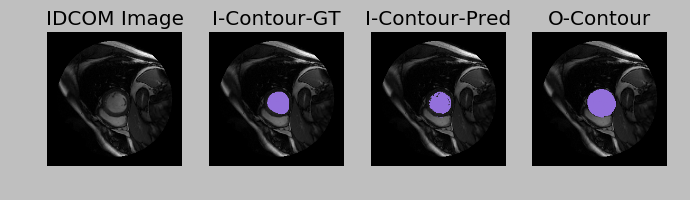

In [35]:
plot_prediction(dicom_example3D, ocontour_example3D, icontour_example3D, icontour_predict3D)

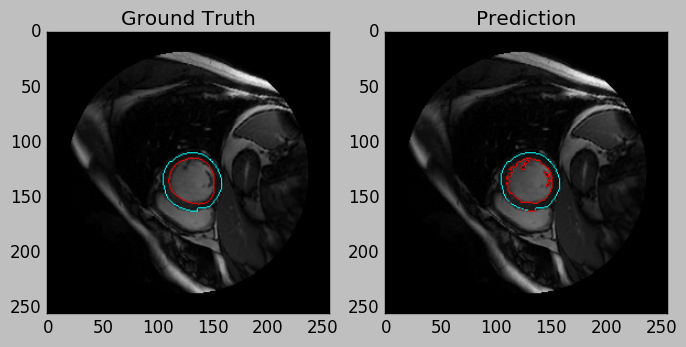

In [36]:
compare_icontour_masks(dicom_example, icontour_example, icontour_predict, ocontour_example)

**Judging from the obtained i-contour outlines, case adaptive thresholding is able to produce smoother and more realistic i-contour polygon prediction than the fixed single-value thresholding method.**

In [37]:
blood_pool = get_blood_pool_pixels(dicom_example, icontour_example)
heart_muscle = get_heart_muscle_pixels(dicom_example, icontour_example, ocontour_example)

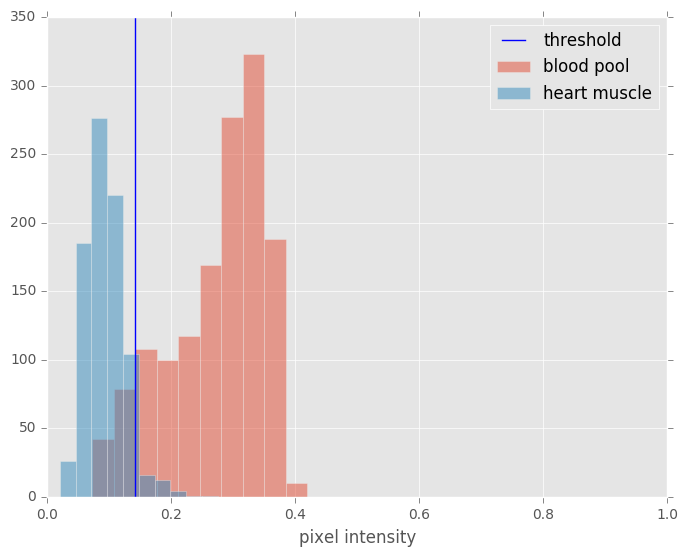

In [38]:
compare_pixel_intensity_with_threshold(blood_pool, heart_muscle, threshold)

In [39]:
IOU_score = comp_IOU(icontour_predict, icontour_example)
print('Intersection Over Union Score of fixed value thresholding on one example: %.4f' % (IOU_score))

Intersection Over Union Score of fixed value thresholding on one example: 0.8815


- ***Case 2 - sample ID: 5***

In [40]:
dicom_example = dicoms[5]
ocontour_example = ocontours[5]
icontour_example = icontours[5]

In [41]:
icontour_predict, threshold = case_adaptive_thresholding(dicom_example, ocontour_example)

In [42]:
dicom_example3D = np.repeat(dicom_example[:, :, None], 3, 2)
ocontour_example3D = np.repeat(ocontour_example[:, :, None], 3, 2)
icontour_example3D = np.repeat(icontour_example[:, :, None], 3, 2)
icontour_predict3D = np.repeat(icontour_predict[:, :, None], 3, 2)

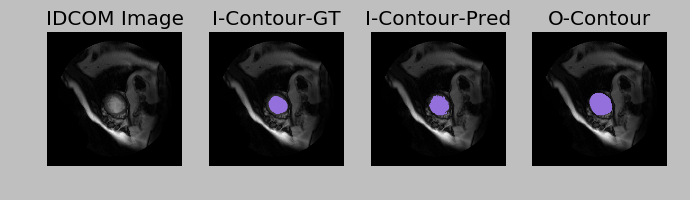

In [43]:
plot_prediction(dicom_example3D, ocontour_example3D, icontour_example3D, icontour_predict3D)

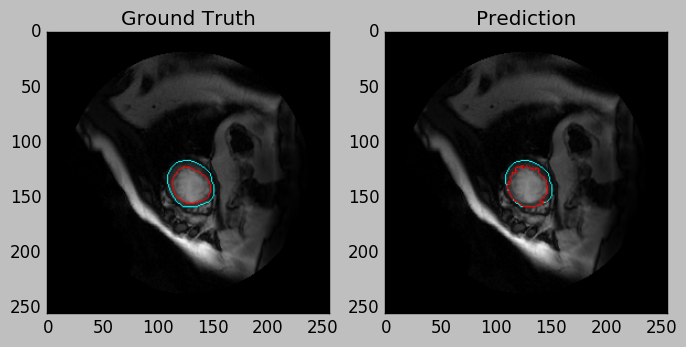

In [44]:
compare_icontour_masks(dicom_example, icontour_example, icontour_predict, ocontour_example)

In [45]:
blood_pool = get_blood_pool_pixels(dicom_example, icontour_example)
heart_muscle = get_heart_muscle_pixels(dicom_example, icontour_example, ocontour_example)

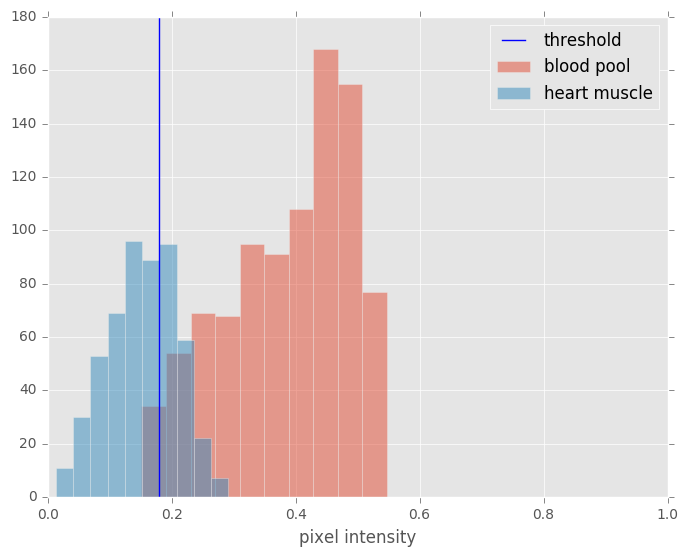

In [46]:
compare_pixel_intensity_with_threshold(blood_pool, heart_muscle, threshold)

In [47]:
IOU_score = comp_IOU(icontour_predict, icontour_example)
print('Intersection Over Union Score of fixed value thresholding on one example: %.4f' % (IOU_score))

Intersection Over Union Score of fixed value thresholding on one example: 0.8139


**Apply case adaptive thresholding scheme to all data samples**

In [48]:
IOU_scores_adathr = []
ada_thresholds = []
for dicom, icontour, ocontour in zip(dicoms, icontours, ocontours):
    icontour_pred, threshold = case_adaptive_thresholding(dicom, ocontour)
    ada_thresholds.append(threshold)
    iou = comp_IOU(icontour_pred, icontour)
    IOU_scores_adathr.append(iou)

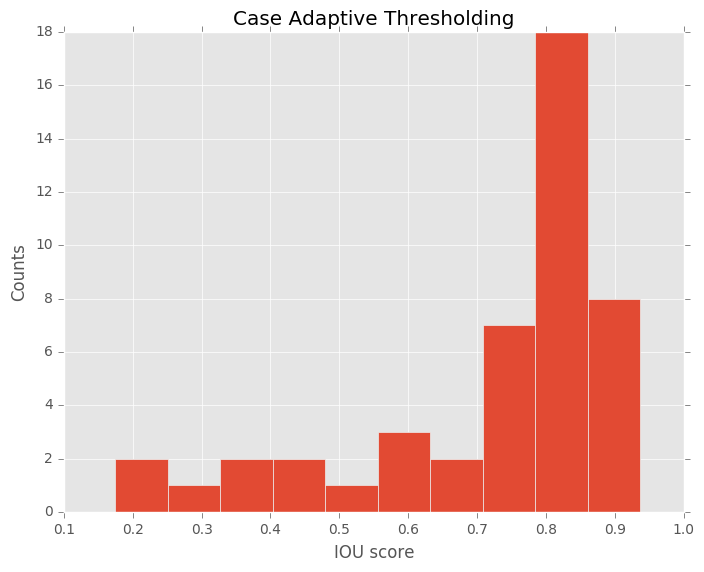

In [49]:
plt.style.use('ggplot')
plt.hist(IOU_scores_adathr)
plt.xlabel('IOU score')
plt.ylabel('Counts')
plt.title('Case Adaptive Thresholding')
plt.show()

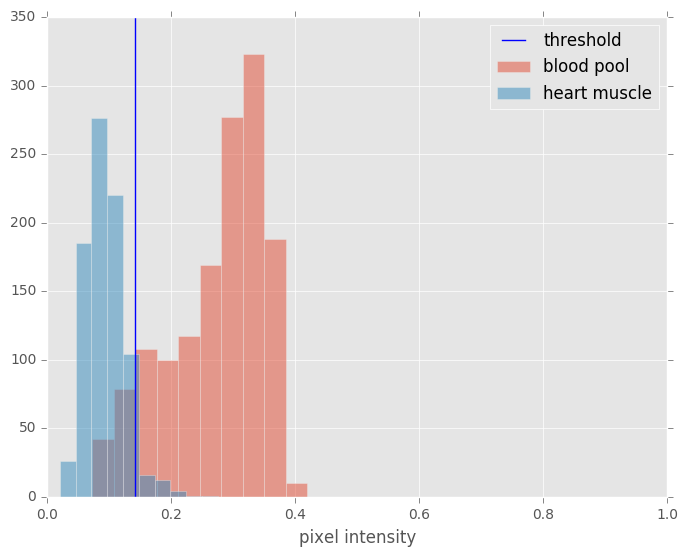

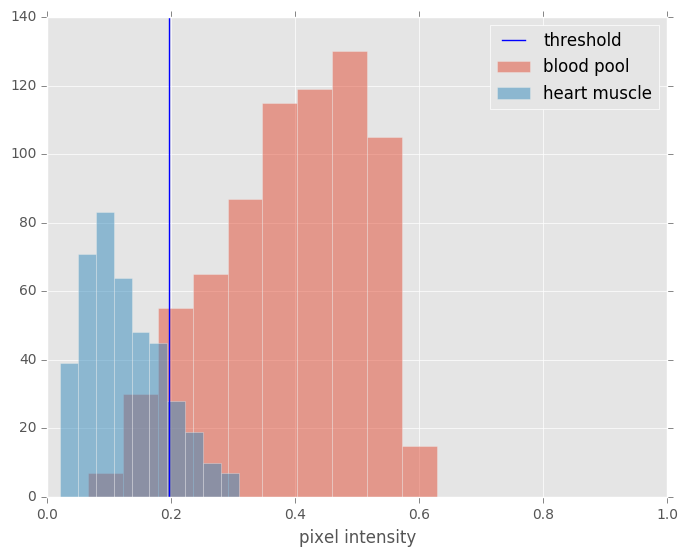

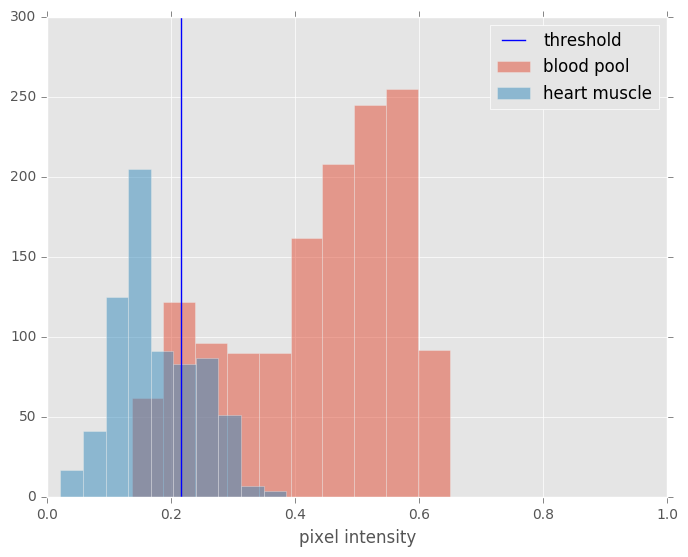

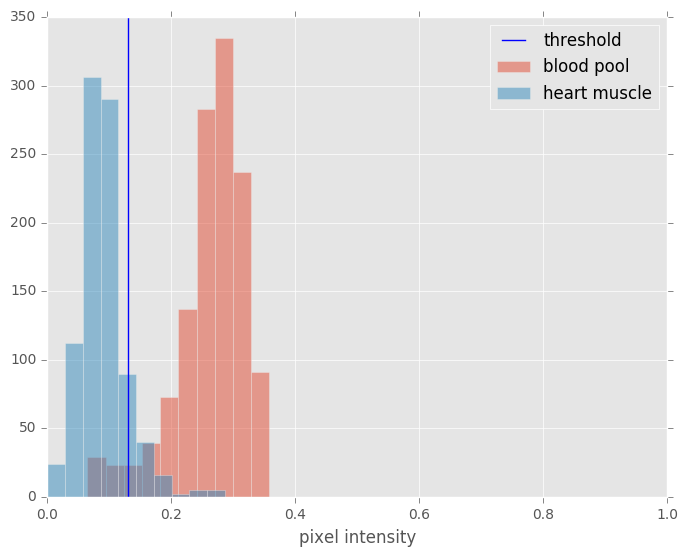

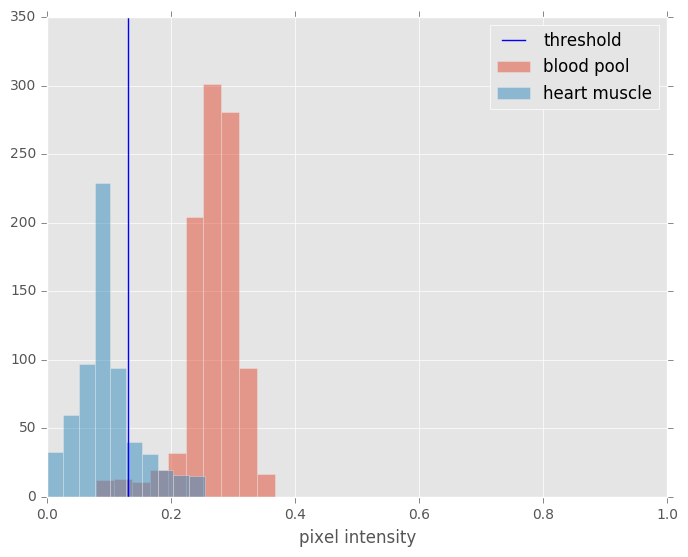

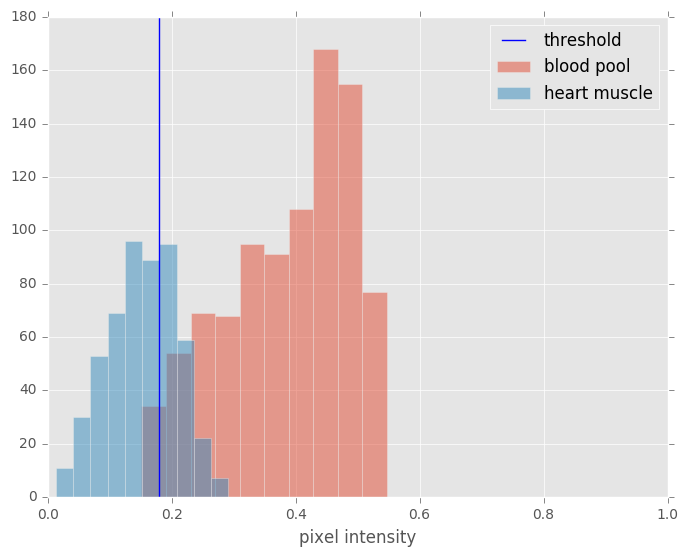

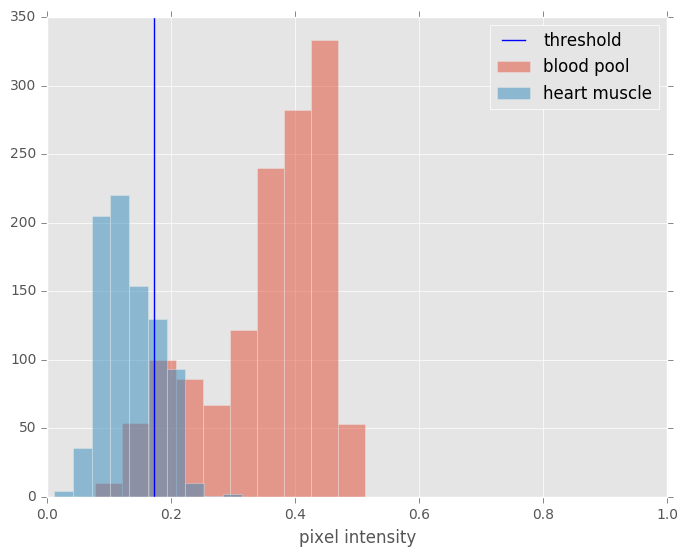

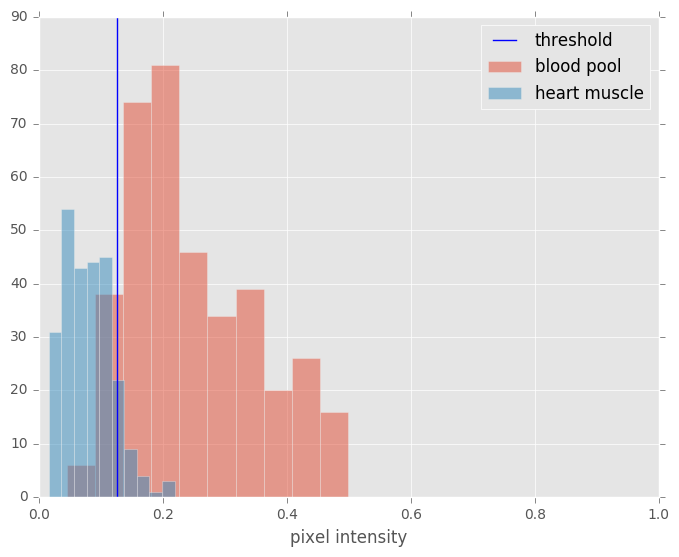

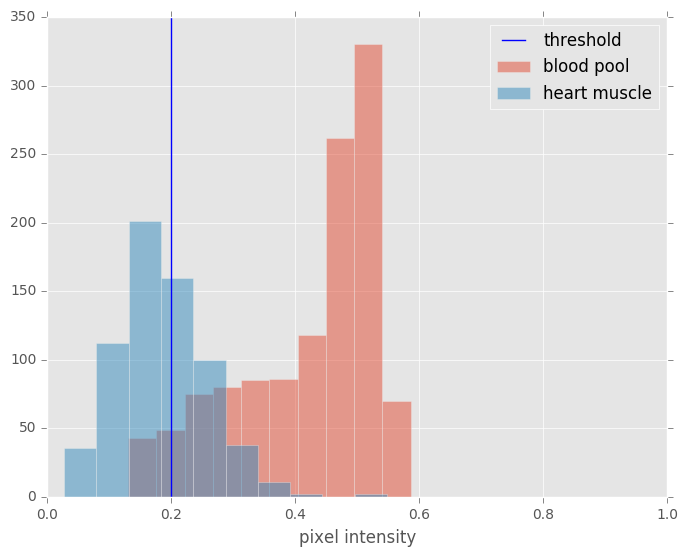

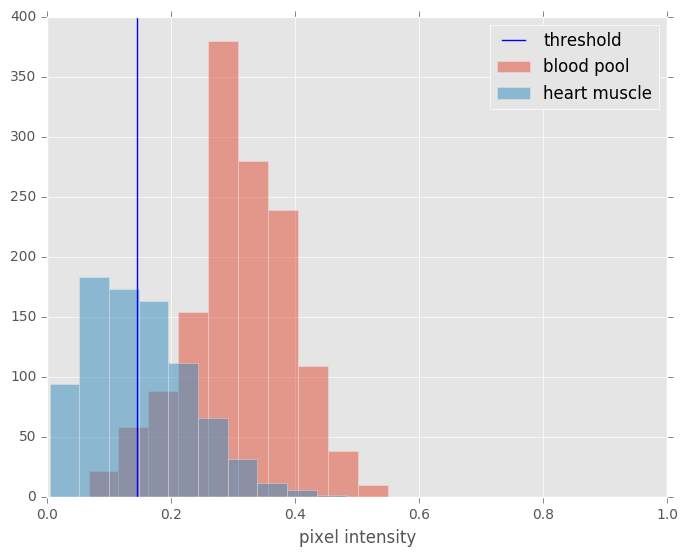

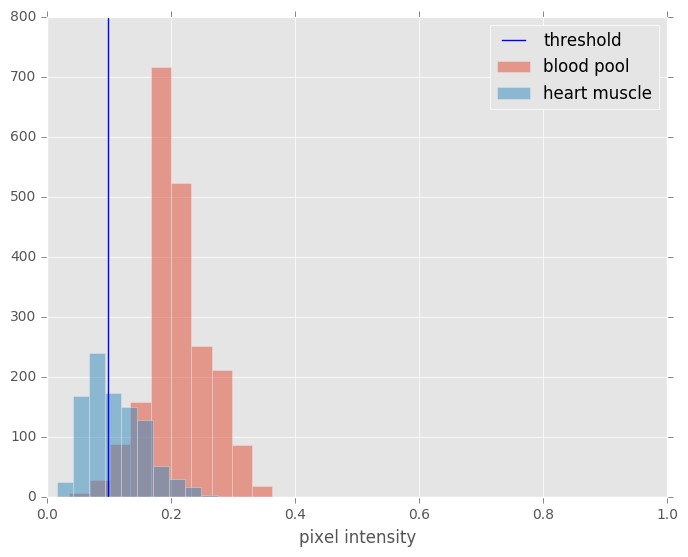

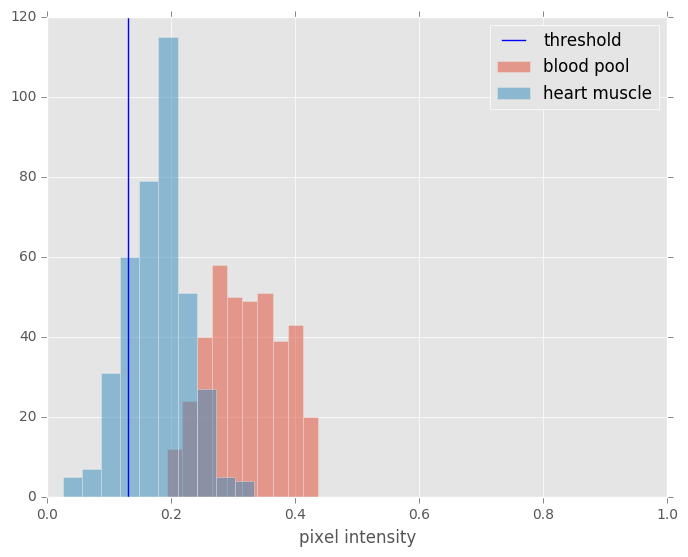

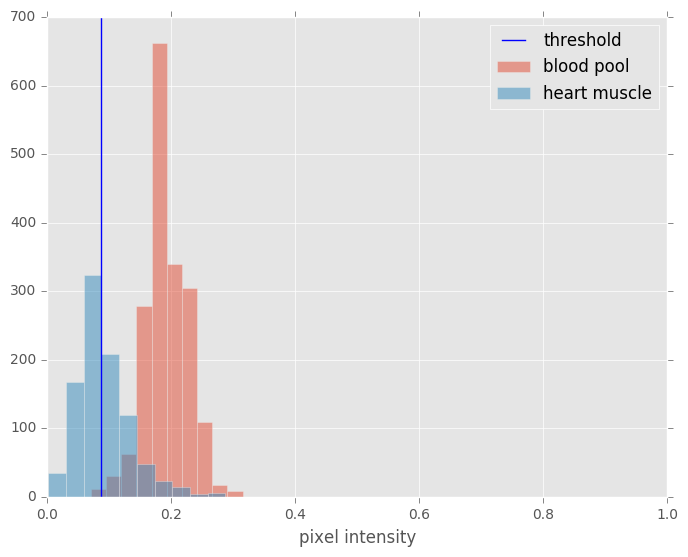

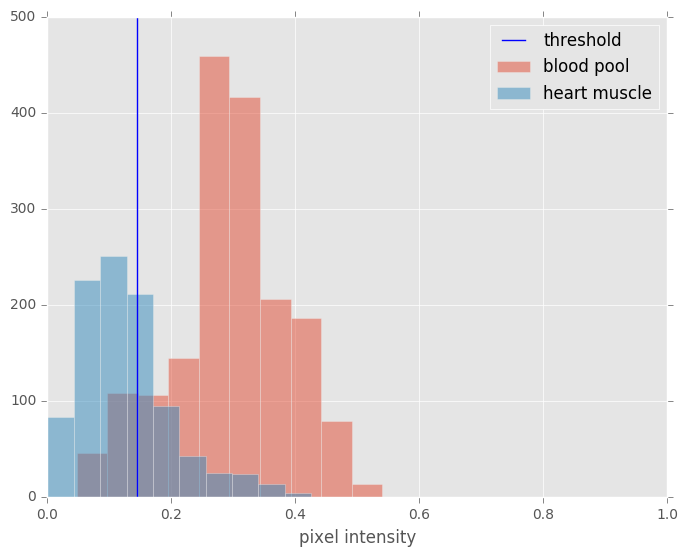

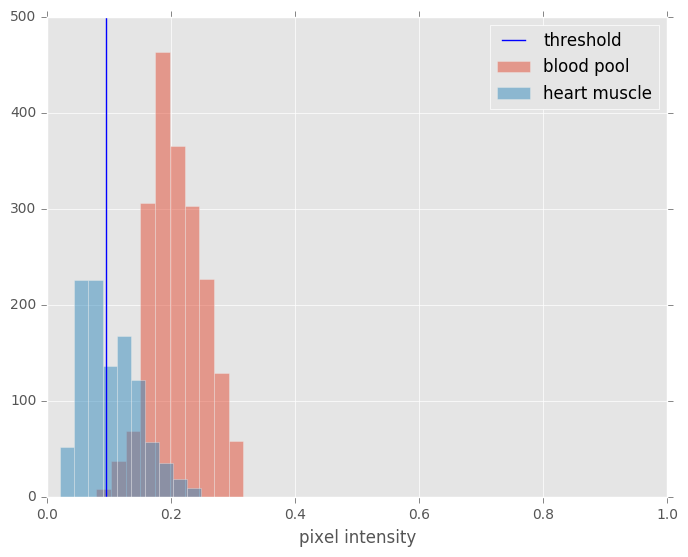

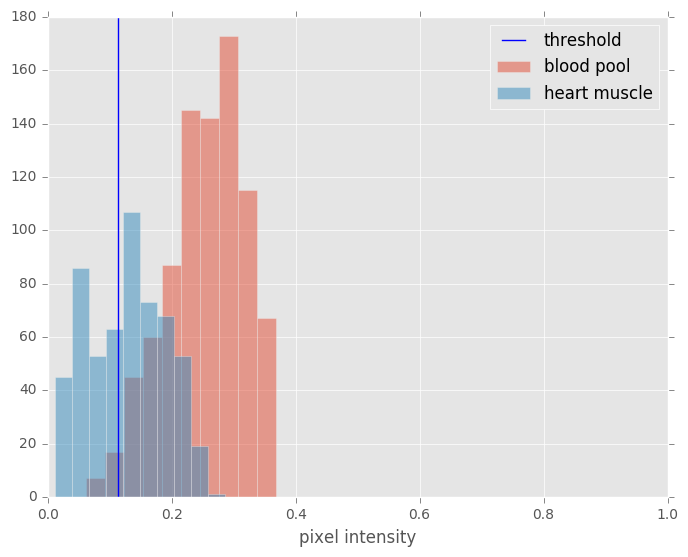

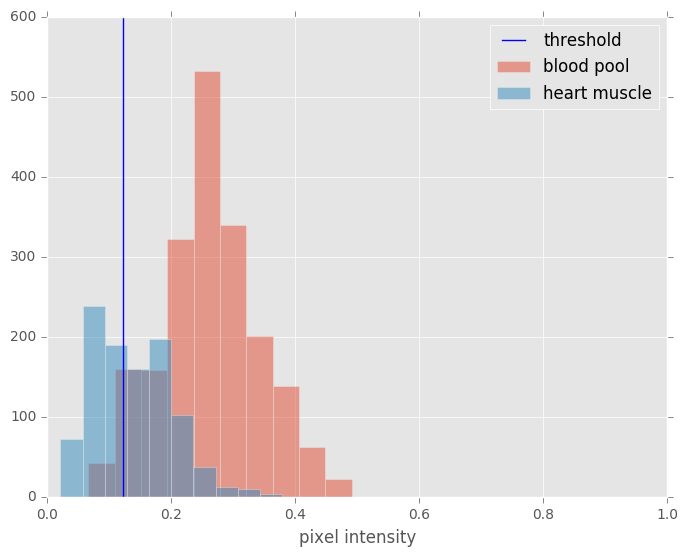

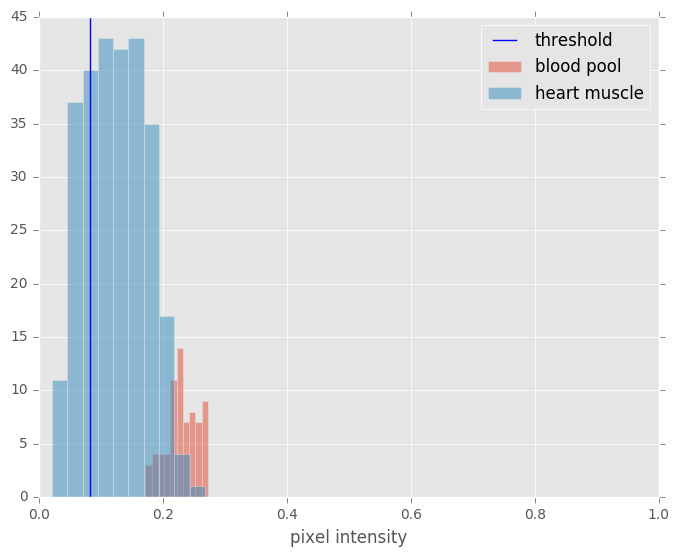

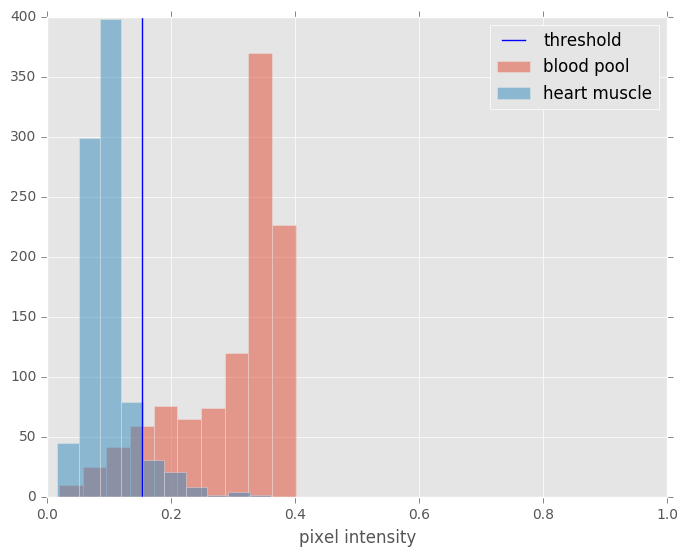

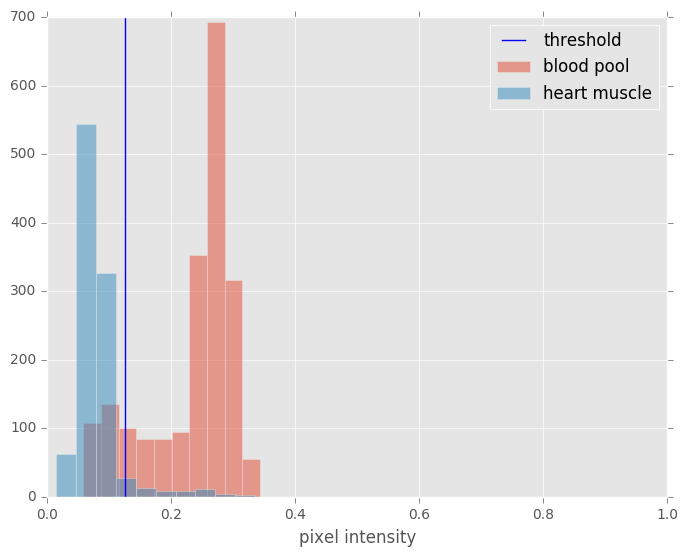

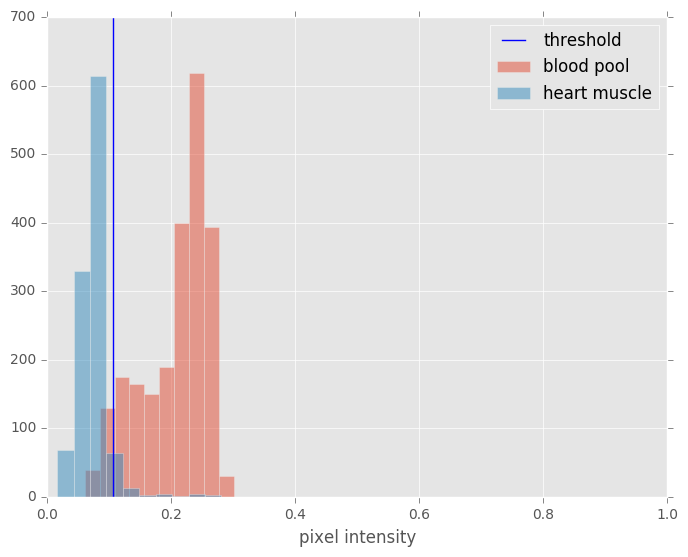

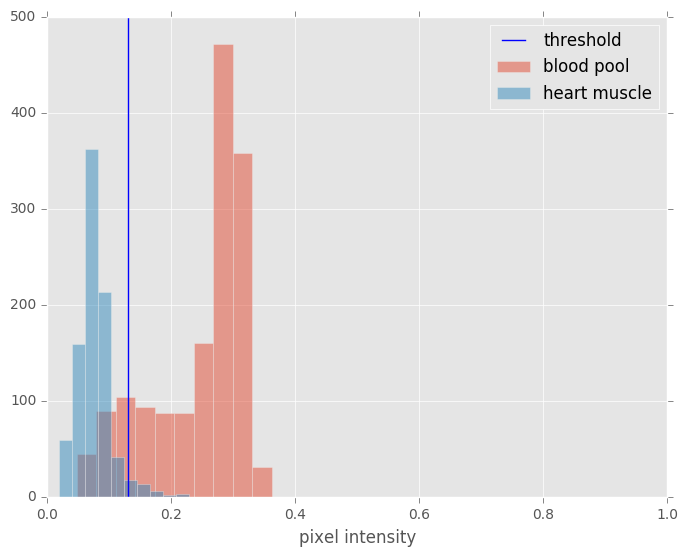

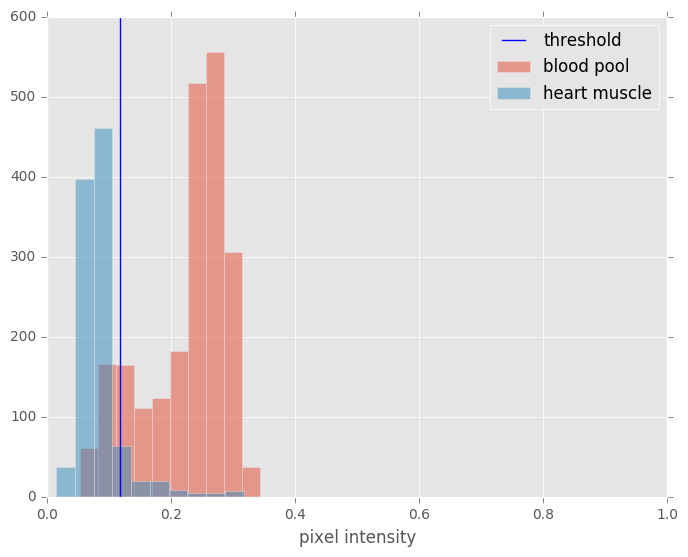

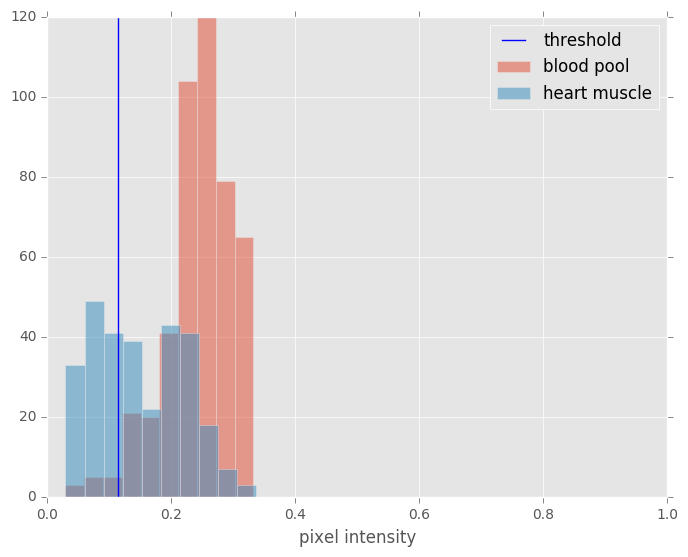

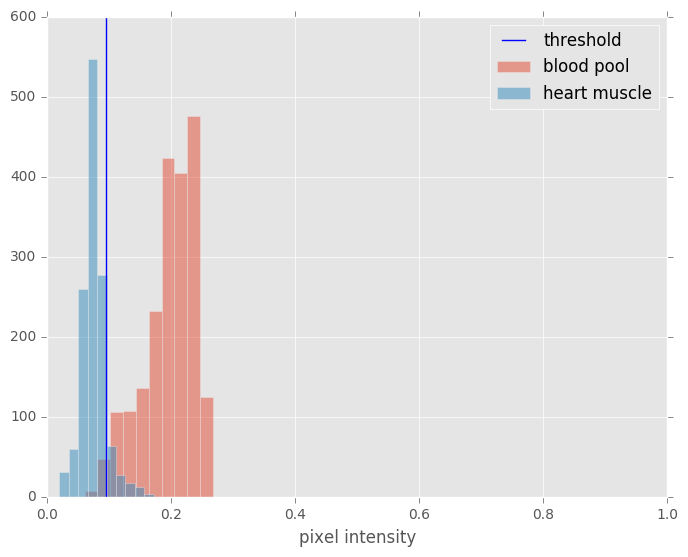

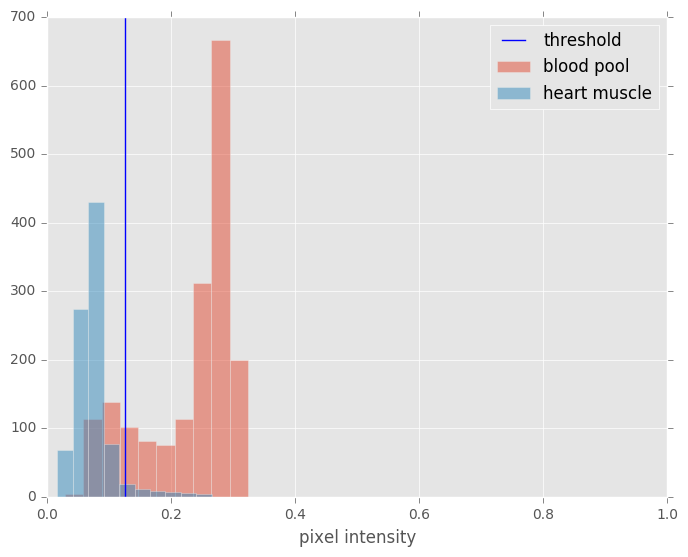

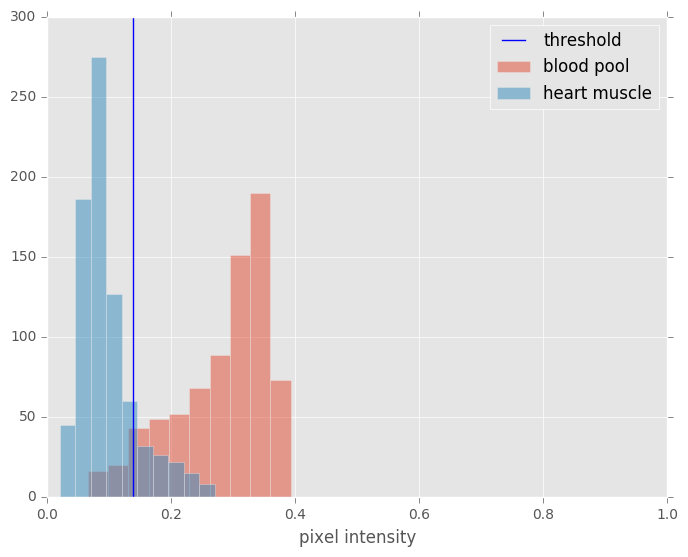

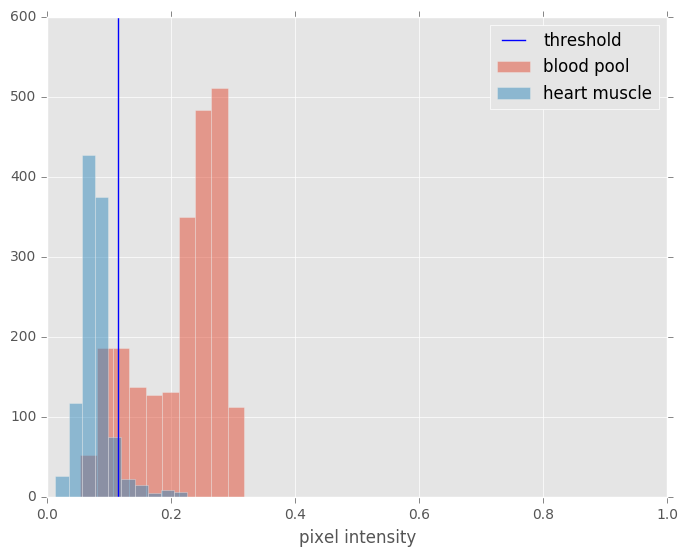

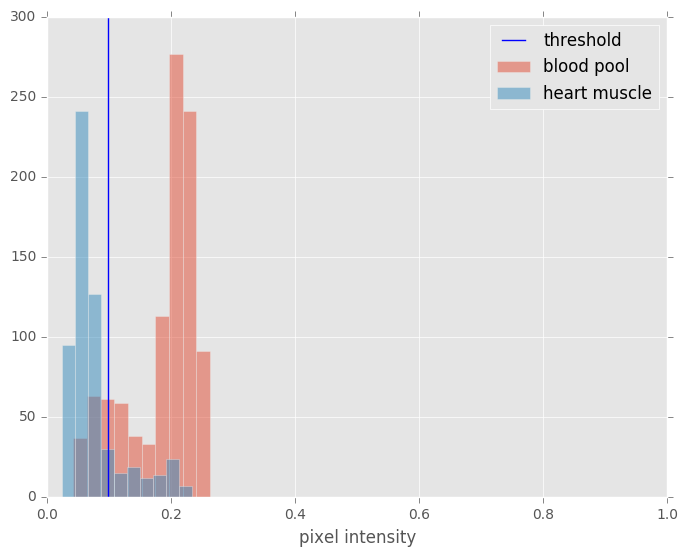

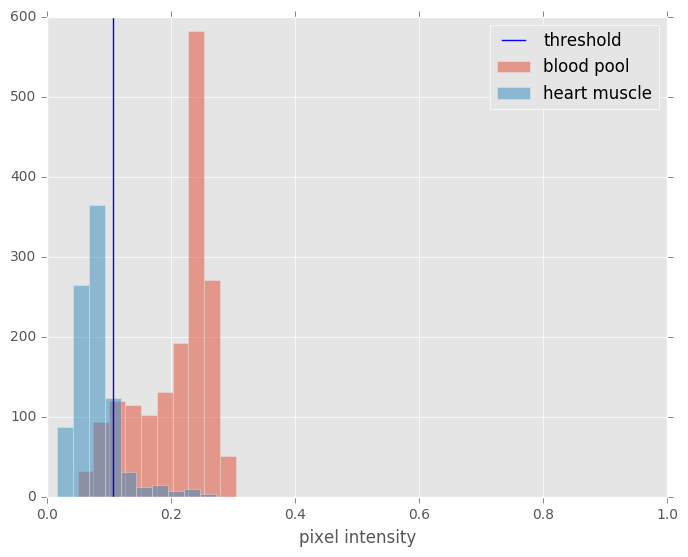

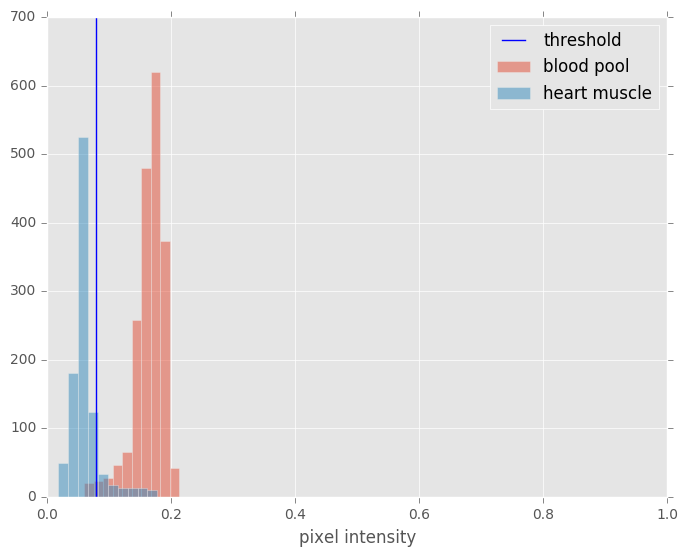

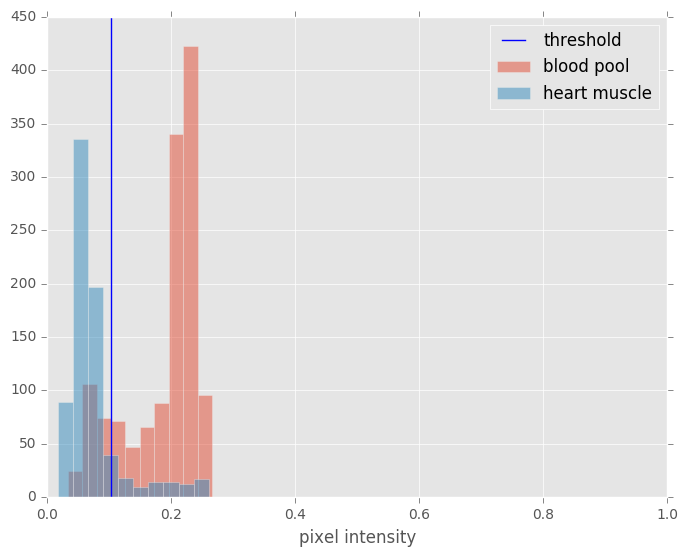

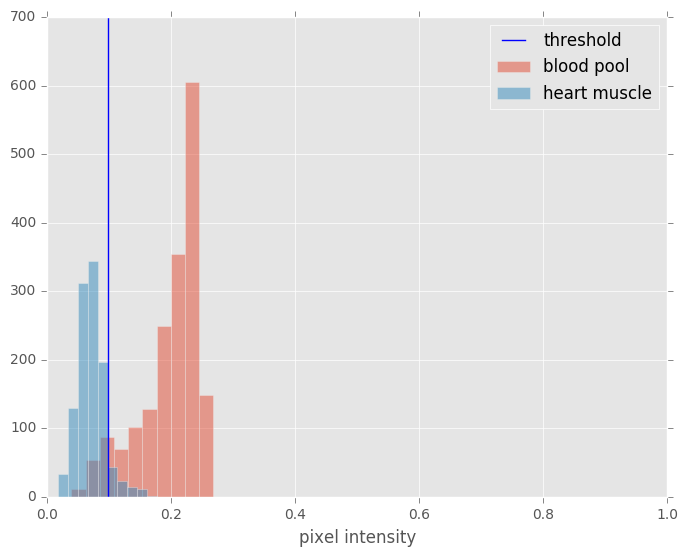

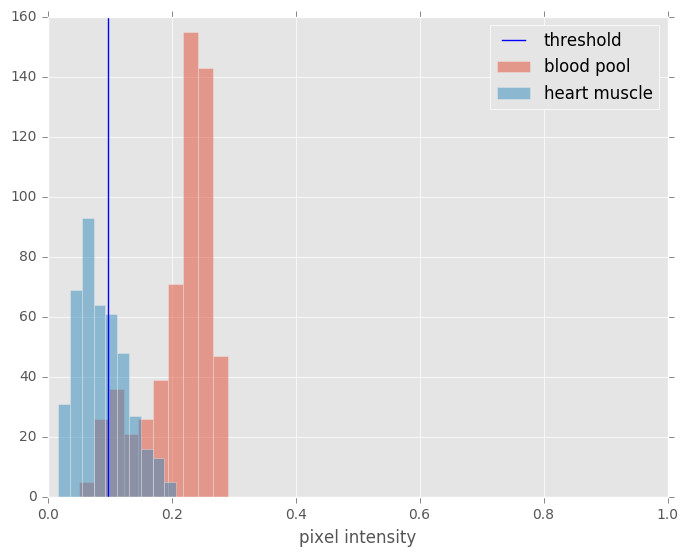

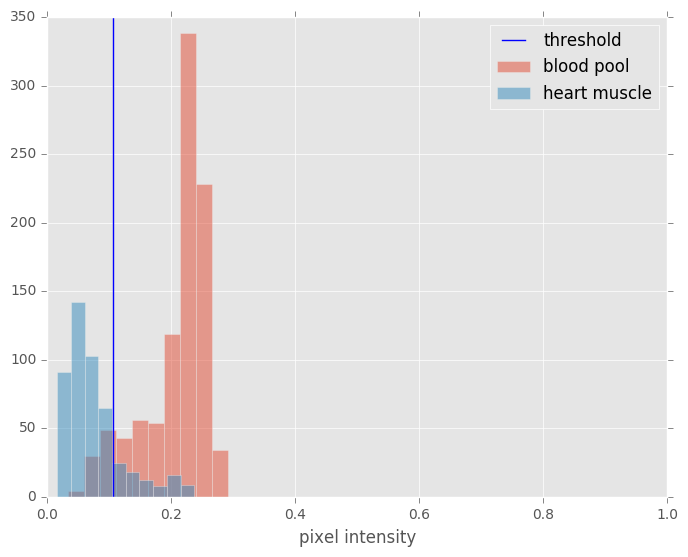

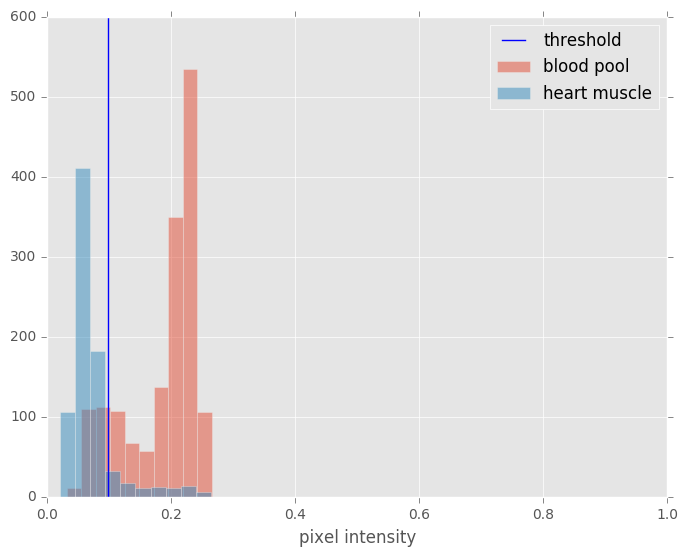

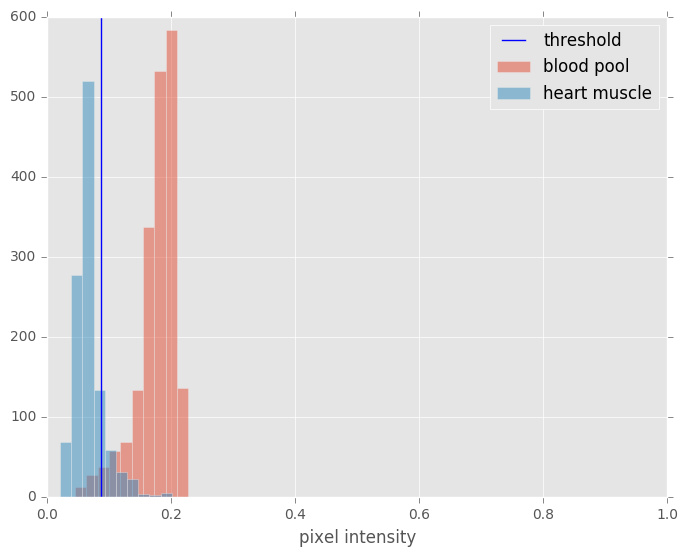

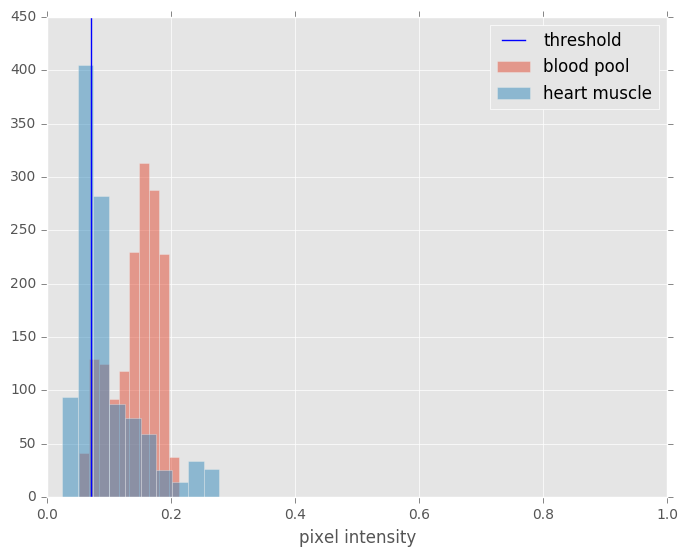

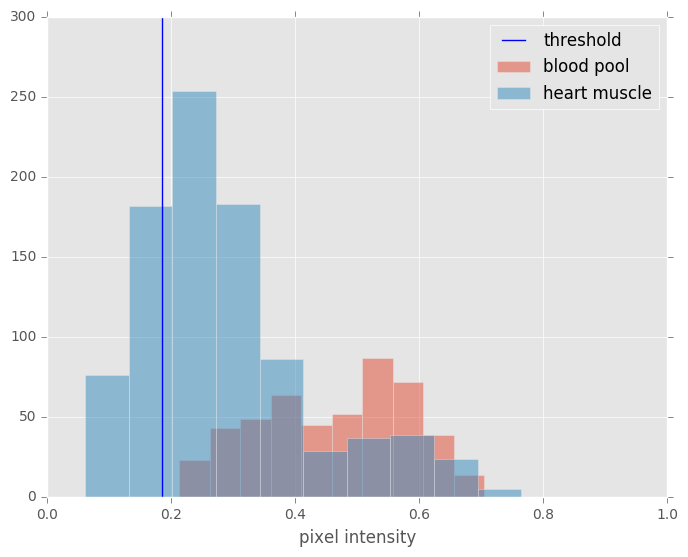

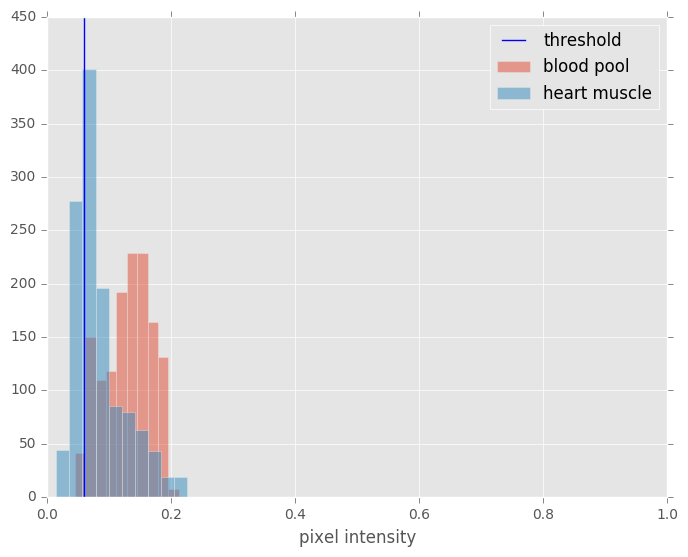

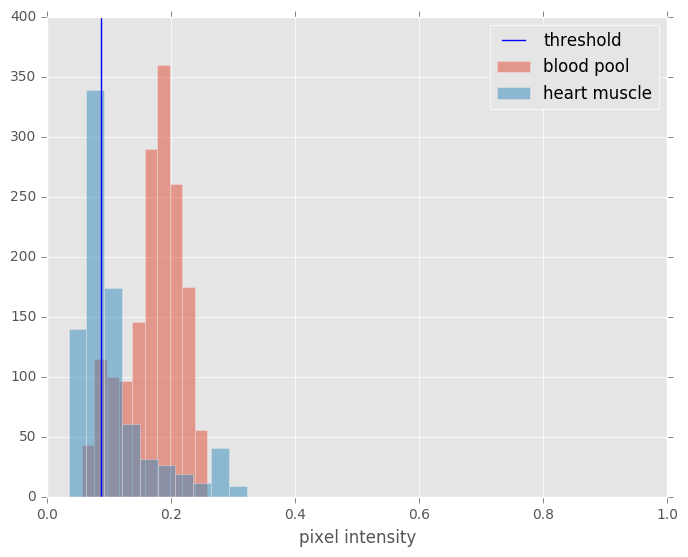

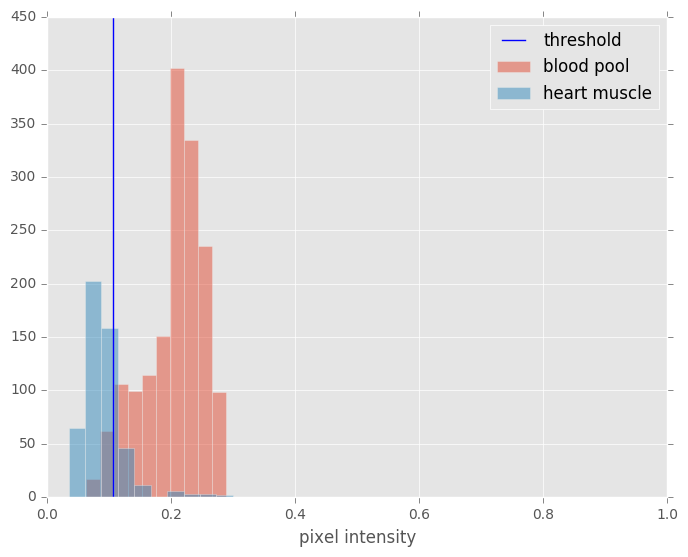

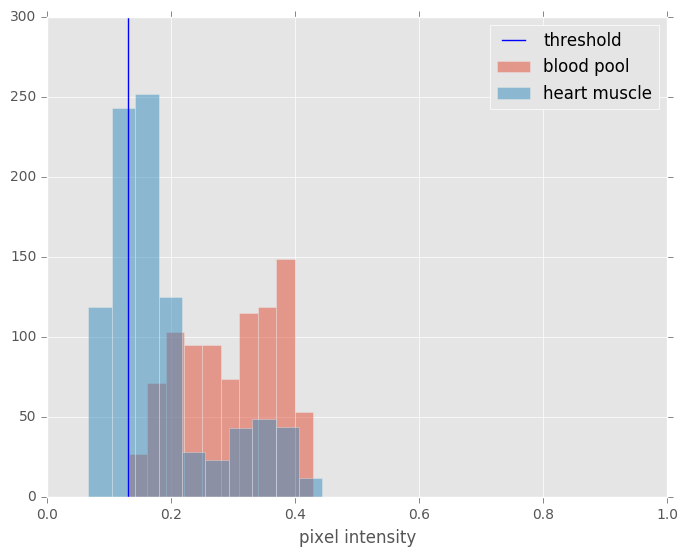

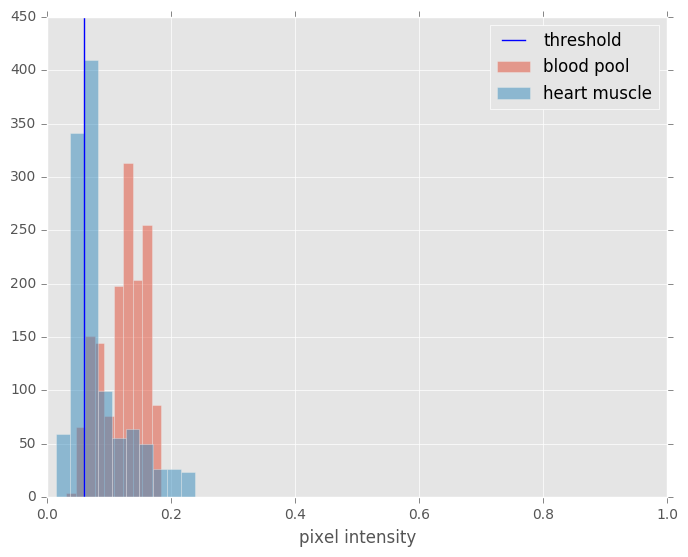

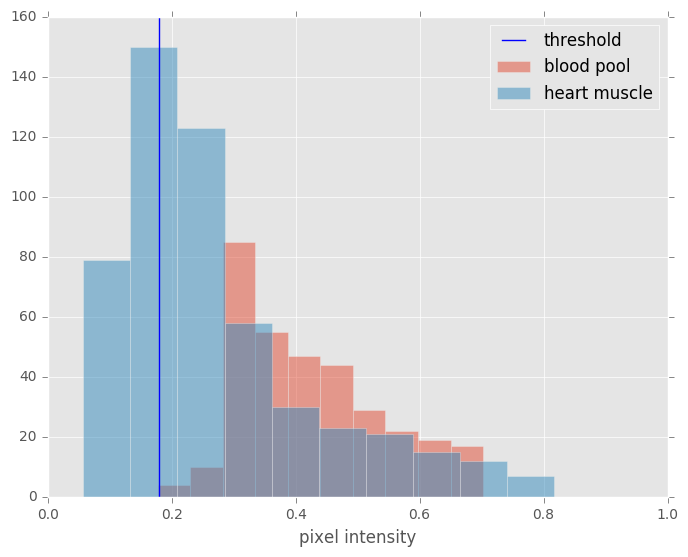

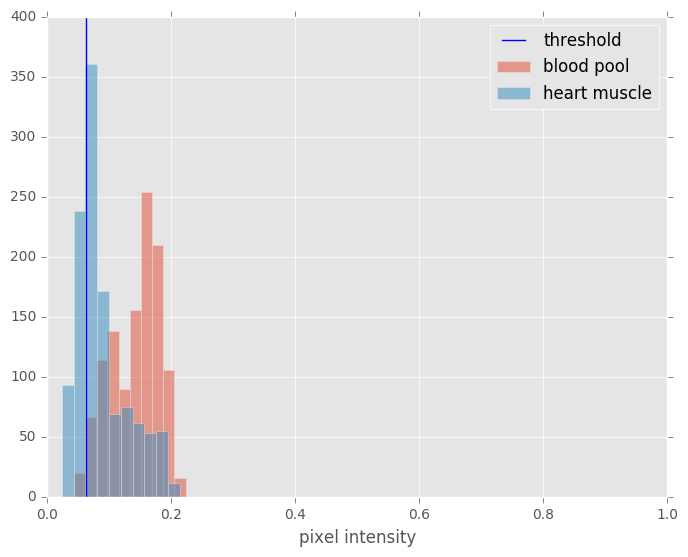

In [50]:
for blood_pool, heart_muscle, threshold in zip(blood_pool_pixels, heart_muscle_pixels, ada_thresholds):
    compare_pixel_intensity_with_threshold(blood_pool, heart_muscle, threshold)

In [51]:
avg_adathr, std_adathr = IOU_stats(IOU_scores_adathr)

Mean of IOU scores: 0.7246 	 Standard Deviation of IOU scores: 0.1999


### Summary of Case Adaptive Thresholding Scheme

The case adaptive thresholding scheme produces better result (a **mean IOU score of 0.7246** and a **standard deviation of 0.1999**) than fixed single-value thresholding scheme as expected. The case adaptive feature of this scheme offers automatically adjustment of the thresholding value based upon each input image sample. This method achieves better IOU scores and out performs the single fixed-value thresholding scheme on the cases when the pixel intensities of the blood pool and heart muscle overlap significantly. However, because of the fact that the pixel intensities of these two types always overlap and are unseperable, the obtained IOU scores through case adaptive thresholding are still not very satisfactory.

### Are there any other heuristic (non-machine learning)-based approaches, besides simple thresholding, would work in this case? Explain.


In the following section, an image segmentation algorithm called Waterthed is being explored and compared to the previous two methods'.


### Watershed Algorithm for Image Segmentation

In [52]:
def watershed_image_seg(dicom, ocontour):
    """Watershed algorithm for finding i-contour."""
    
    import cv2
    
    image_gray = (255 * dicom * ocontour).astype(np.uint8)
    threshold, icontour = cv2.threshold(image_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # remove noise
    kernel = np.ones((3,3), np.uint8)
    opening = cv2.morphologyEx(icontour, cv2.MORPH_OPEN, kernel, iterations = 2)
    
    # find sure background area
    sure_bg = cv2.dilate(opening, kernel,iterations=3)
    
    # find sure foreground area
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
    
    # find uncertain area
    sure_bg = np.uint8(sure_bg)
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)
    
    # label marker
    ret, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0
    
    # apply watershed algorithm
    image3D = np.repeat(image_gray[:, :, None], 3, 2)
    markers = cv2.watershed(image3D, markers)
    
    # unmark image frame
    row, col = markers.shape
    markers[0, :] = 1
    markers[:, 0] = 1
    markers[row - 1, :] = 1
    markers[:, col - 1] = 1
    
    # build predicted icontour boolean mask from markers
    icontour_pred_mask = markers.copy()
    icontour_pred_mask[markers == 2] = -1
    return icontour_pred_mask < 0

**A Case Example**
- ***Case 1 - sample ID: 0***

In [53]:
dicom_example = dicoms[0]
ocontour_example = ocontours[0]
icontour_example = icontours[0]

In [54]:
icontour_predict = watershed_image_seg(dicom_example, ocontour_example)

In [55]:
dicom_example3D = np.repeat(dicom_example[:, :, None], 3, 2)
ocontour_example3D = np.repeat(ocontour_example[:, :, None], 3, 2)
icontour_example3D = np.repeat(icontour_example[:, :, None], 3, 2)
icontour_predict3D = np.repeat(icontour_predict[:, :, None], 3, 2)

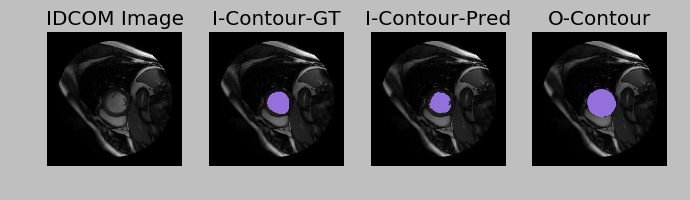

In [56]:
plot_prediction(dicom_example3D, ocontour_example3D, icontour_example3D, icontour_predict3D)

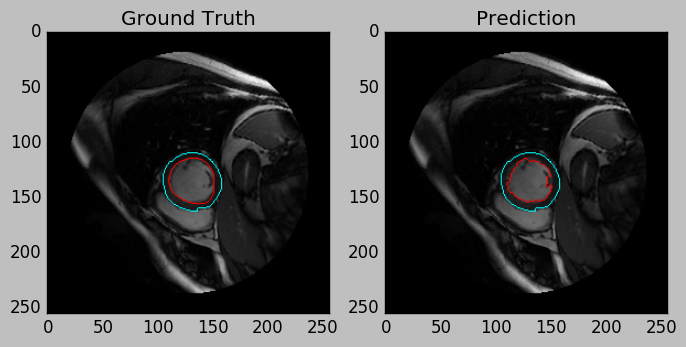

In [57]:
compare_icontour_masks(dicom_example, icontour_example, icontour_predict, ocontour_example)

In [58]:
IOU_score = comp_IOU(icontour_predict, icontour_example)
print('Intersection Over Union Score of fixed value thresholding on one example: %.4f' % (IOU_score))

Intersection Over Union Score of fixed value thresholding on one example: 0.8470


- ***Case 2 - sample ID: 3***

In [59]:
dicom_example = dicoms[3]
ocontour_example = ocontours[3]
icontour_example = icontours[3]

In [60]:
icontour_predict = watershed_image_seg(dicom_example, ocontour_example)

In [61]:
dicom_example3D = np.repeat(dicom_example[:, :, None], 3, 2)
ocontour_example3D = np.repeat(ocontour_example[:, :, None], 3, 2)
icontour_example3D = np.repeat(icontour_example[:, :, None], 3, 2)
icontour_predict3D = np.repeat(icontour_predict[:, :, None], 3, 2)

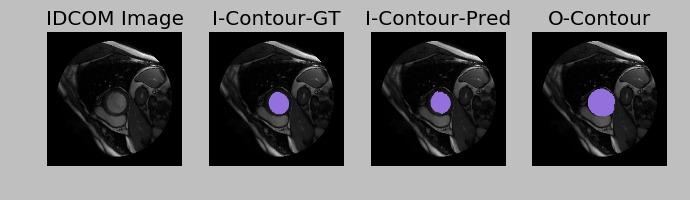

In [62]:
plot_prediction(dicom_example3D, ocontour_example3D, icontour_example3D, icontour_predict3D)

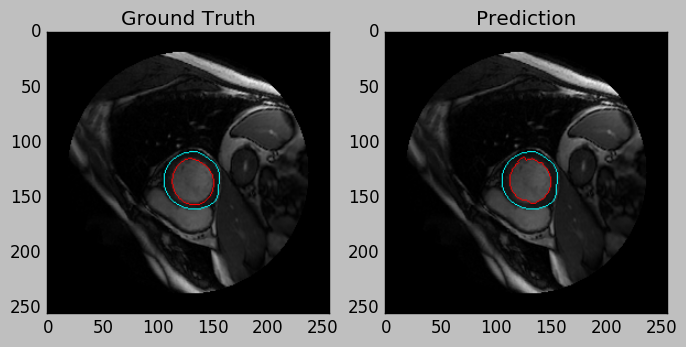

In [63]:
compare_icontour_masks(dicom_example, icontour_example, icontour_predict, ocontour_example)

In [64]:
IOU_score = comp_IOU(icontour_predict, icontour_example)
print('Intersection Over Union Score of fixed value thresholding on one example: %.4f' % (IOU_score))

Intersection Over Union Score of fixed value thresholding on one example: 0.9080


**Apply case adaptive thresholding scheme to all data samples**

In [65]:
IOU_scores_watershed = []
for dicom, icontour, ocontour in zip(dicoms, icontours, ocontours):
    icontour_pred = watershed_image_seg(dicom, ocontour)
    iou = comp_IOU(icontour_pred, icontour)
    IOU_scores_watershed.append(iou)

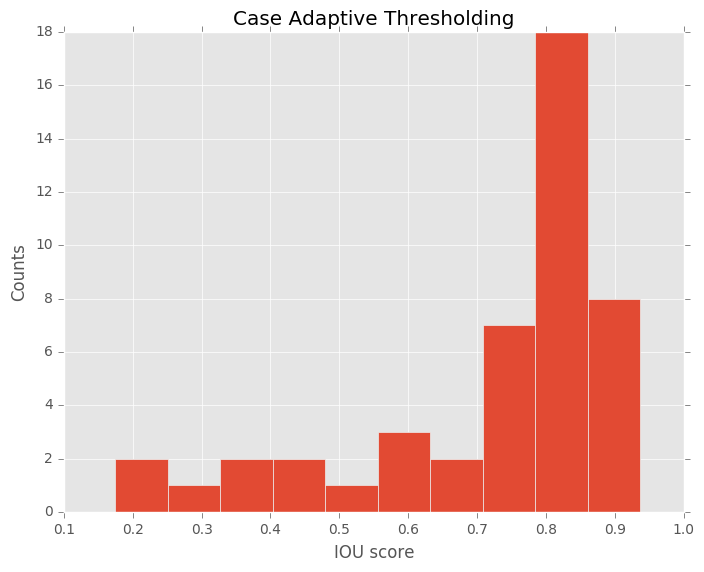

In [66]:
plt.style.use('ggplot')
plt.hist(IOU_scores_adathr)
plt.xlabel('IOU score')
plt.ylabel('Counts')
plt.title('Case Adaptive Thresholding')
plt.show()

In [67]:
avg_watershed, std_watershed = IOU_stats(IOU_scores_watershed)

Mean of IOU scores: 0.7147 	 Standard Deviation of IOU scores: 0.1731


### Summary of Watershed Segmentation Algorithm

The watershed segmentation algorithm achieves somewhat similar performance as case adaptive thresholding: with a **mean IOU score of 0.7147**, which is marginally smaller than case adaptive thresholding, and with a **standard deviation of 0.1731**, which out performs the case adaptive thresholding. Judging from the plots, watershed segmentation seems to produce smooth i-contour outlines, although it still performs not so well on the cases when the pixel intensities of blood pool and heart muscle overlaps heavily. The mean IOU score is still not very satisfactory.

### Other Heuristic LV Segmentation approaches

There are a few other heuristic LV segmentations approaches that people have been using and they can roughly been summrized into the following categories:
- Thresholding
- Clustering
- Graph-based Algorithms
- Active Shape Models
- Probablistic Graphic Models

If more time were given, it'd be interesting to explore how well clustering and gradient flow graph-search algorithms would perform in comparison to the ones that have been explored here.